## PHYS20762 Project 2  - Numerical integration
ID: 10891400 <br>
University of Manchester <br>
11/04/2024 <br>
The values assigned to me were: $k = 2.76$ kgs$^{-1}$, $m=4.33$ kg <br>
Note: All values in this notebook are in SI units unless stated otherwise.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import time as timer
from matplotlib.animation import FuncAnimation
from IPython import display
plt.style.use('default')

In [79]:
SPRING_CONSTANT = 2.76 # [kg/s^2]
MASS = 4.33 # [kg]
CRITICAL_DAMPING = np.sqrt(4*MASS*SPRING_CONSTANT) # [kg/s]
DAMPING_CONSTANT = 0.01*CRITICAL_DAMPING # [kg/s] 
PERIOD = 2*np.pi*np.sqrt(MASS/SPRING_CONSTANT) # [s]

Numerical methods invoke algorithms to solve systems of equations, analyse data/ curve fit, solve ordinary and partial differential equations,simulate physical experiments as in the Monte Carlo method etc. This notebook focuses on solving the initial value problem ODEs by using iterative methods, specifically damped oscillation.

## <center> The Damped Harmonic Oscillator  $$m\frac{d^2x}{dt^2} + b\frac{dx}{dt} + kx = F(t).$$<center>

### Phase 1 - The Methods Themselves for $F(t)=0$

**Euler method**
<br>The explicit Euler is a first order method for numerical integration. For some acceleration $a(t,x,v)$, from their respective first order taylor expansions, the velocity after a small time $h$ will be $v(t+h) = v(t) + ha(t)$, similarly position $x(t+h) = x(t) + hv(t)$. Given some inital conditions $x(0) = x_0$, and $v(0) = v_0$, the subsequent position and velocity at any time $t$ can be calculated. The Euler method is given below, where the $(i+1)^{\text{th}}$ index gives the value of the quantity after a time step.
$$
\text{The Euler method: }
\begin{cases}
    a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i\\
    v_{i+1} = v_i + ha_i \\
    x_{i+1} = x_i + hv_i 
\end{cases}
$$
<br>**Euler method error.** 
<br>Since its a first order method, the local truncation error (error per step) is proportional to $h^2$, and global truncation error (error at any time) is proportional to $h$. Taylor expanding velocity $v(t+h)$:
$$
v(t+h) = v(t) + hv'(t) + \frac{1}{2}h^2v''(\epsilon),
$$
where $t < \epsilon < t+h$. Since the Euler methods $v_{i+1} = v_i + ha_i$, taking the difference gives the error:
$$
\begin{align}
\text{error} = v(t+h)-v_{i+1}&= \color{red}{v(t) + hv'(t)} + \frac{1}{2}h^2v''(\epsilon)\color{red}{ - v_i - ha_i} \\
\text{error}&=\frac{1}{2}h^2v''(\epsilon)
\end{align}
$$
so the local trunaction error for is of order $h^2$ or $O(h^2)$. The global error can be found by multiplying the local error by the number of steps $N = {T}/{h}$ where $T$ is the total runtime. So the global error for Euler method is of order $O(h)$.

We can calulate the energy of our system using $E_{i+1} = \frac{1}{2}mv_{i+1}^2 + \frac{1}{2}kx_{i+1}^2$. For the Euler method with no damping: $x_{i+1} = x_i + hv_i$, $v_{i+1} = v_i + ha_i$ and $a_i = -\frac{k}{m}x_i$ - the energy is increasing - whereas we expected it to stay constant for the no damping case. Specifically $E_{i+1} = E_{i}(1+ \frac{k}{m}h^2)$. Symplectic integrators are those that conserve energy. The Verlet method and Euler-Cromer method described after the Improved Euler method are both symplectic.

In [80]:
def euler_method(initial_position, initial_velocity, final_time, step_size = 1e-3,
                 mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    first order explicit euler method for numerically integrating dampled
    harmonic oscillator. after inputting initial condition and configuration 
    of system finds the subsequent position and velocity. also finds runtime.

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float
        end time of integration in seconds.
    step_size : float, optional
        size of step for integration in seconds. The default is 1e-3.
    mass : float, optional
        the mass m of the oscillator. The default is MASS.
    spring_const : float, optional
        spring constant k of oscillation. The default is SPRING_CONSTANT.
    damping_const : float, optional
        the damping constant b. The default is DAMPING_CONSTANT.

    Returns
    -------
    euler_output : dictionary
        dictionary containting position, velocity, time arrays. the step_size, 
        final_time, mass, spring_constant, damping_constant and runtime floats.
        initial_conditions tuple. name of the procedure, the criticality of 
        oscillation strings. 

    """
    start_time = timer.time()
    # initialise
    h = step_size
    number_steps = int(final_time/h)
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]

    # euler procedure
    for i in range(number_steps-1):
        a = -(spring_const/mass)*x[i] -(damping_const/mass)*v[i]
        x[i+1] = x[i] + v[i]*h
        v[i+1] = v[i] + a*h

    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)
        

    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time() - start_time       
    euler_output = {'position': x, 'velocity': v, 'time' :time_array,
                    'step_size': step_size, 'final_time':final_time,
                    'initial_conditions':(initial_position,initial_velocity),
                    'procedure':'Euler method', 'criticality':criticality,
                    'spring_constant':spring_const, 'mass':mass, 
                    'damping_constant':damping_const, 'runtime':runtime}
    return euler_output

An error of order $O(h)$ implies we can achieve arbitrarily low error by reducing step size. This is not a good idea since after a certain point roundoff errors increase to the point where accuracy starts to reduce. Also having an extremely small step size makes the integration process computationally expensive. This is why other methods with lower error are created.
<br>**Improved Euler method**
<br>This method improves on the basic Euler method by including an extra term in the Taylor expansion for position, $x(t+h) \approx x(t) + v(t)h + \frac{1}{2}a(t)h^2 + O(h^3)$. The Improved Euler methods local truncation error is of order $O(h^3)$, and its global error $O(h^2)$. By inluding the acceleration in the position, we have increased the number of evaluations of our ODE per iteration - this is the cost of reducing the error.
$$
\text{The Improved Euler method: }
\begin{cases}
    a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i \\
    v_{i+1} = v_i + ha_i \\    
    x_{i+1} = x_i + hv_i + \frac{h^2}{2}a_i \\
\end{cases}
$$

In [81]:
def improved_euler_method(initial_position, initial_velocity, final_time, step_size = 1e-3,
                          mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    the improved euler method numerical integrator for damped harmonic 
    oscillator. inputting initial condition and configuration 
    of system and outputting the subsequent position and velocity. 
    also finds runtime.

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float
        end time of integration in seconds.
    step_size : float, optional
        size of step for integration in seconds. The default is 1e-3.
    mass : float, optional
        the mass m of the oscillator. The default is MASS.
    spring_const : float, optional
        spring constant k of oscillation. The default is SPRING_CONSTANT.
    damping_const : float, optional
        the damping constant b. The default is DAMPING_CONSTANT.

    Returns
    -------
    improved_euler_output : dictionary
        dictionary containting position, velocity, time arrays. the step_size, 
        final_time, mass, spring_constant, damping_constant and runtime floats.
        initial_conditions tuple. name of the procedure, the criticality of 
        oscillation strings. 

    """
    start_time = timer.time()
    # initialise
    h = step_size
    number_steps = int(final_time/h)
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]

    # improved euler procedure
    for i in range(number_steps-1):
        a = -(spring_const/mass)*x[i] -(damping_const/mass)*v[i]
        x[i+1] = x[i] + v[i]*h + a*(h**2/2)
        v[i+1] = v[i] + a*h

    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)

    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time() - start_time
    improved_euler_output = {'position': x, 'velocity': v,'time' :time_array,
                             'step_size': step_size, 'final_time':final_time,
                             'initial_conditions':(initial_position,initial_velocity),
                             'procedure': 'Improved Euler method', 'criticality':criticality,
                             'spring_constant':spring_const, 'mass':mass, 
                             'damping_constant':damping_const, 'runtime':runtime}
    return improved_euler_output

Both the Euler and improved Euler methods are explicit and forward methods of numerical integration. They are methods that calculate the state of a system at some later time using the current or previous states - in other words they aim to find $x(t+h)$ using some calculation involving $x(t)$, $x(t+h) = f(x(t))$. There also exist implicit methods - where itermediate calculations need to be performed before all values can be computed. Implicit methods may hold up better when integrating stiff functions - not requiring a vanishingly small time step to give stable results. Check the note at the end of this phase for more information about stiff functions. One such implicit method is the Verlet method described below.
<br>**Verlet method**
<br> This is an implicit method derived from the centred derivative as the starting point. This method symmetric in time and can be used as a negative time version, where instead of initial conditions the final conditions are used to find some previous state. This method is also symplectic - energy is conserved (or at least the energy oscillates around its conserved value). The method is derived using the centred derivative:
$$
x'(t)=  \lim_{h \to 0} \frac{x(t+h)-x(t-h)}{2h}
$$
we can write the taylor expansions for these two terms: 
$$
\begin{align}
x(t+h) &= x(t) + hx'(t) +\frac{1}{2}h^2x''(t) + \frac{1}{6}h^3x'''(\epsilon) \\
x(t-h)&= x(t) \color{red}{-} hx'(t) +\frac{1}{2}h^2x''(t) \color{red}{-} \frac{1}{6}h^3x'''(\epsilon)
\end{align}
$$
where $t-h < \epsilon < t+h$. Now subtracting these we obtain:
$$
x'(t) = \frac{x(t+h)-x(t-h)}{2h} = \frac{2hx'(t) + 2\frac{1}{6}h^3x'''(\epsilon)}{2h} = x'(t) + \frac{1}{6}h^2x'''(\epsilon).
$$
And also we can get by rearranging:
$$
x''(t) = \frac{x(t+h)+x(t-h)-2x(t)}{h^2} - \frac{1}{12}h^2x^{(4)}(\epsilon)
$$
Both of these are quadratic in $h$, meaning errors are of order $O(h^2)$. The above can be written in discretised notation to give: 
$$ \begin{align}
&v_i = \frac{x_{i+1}-x_{i-1}}{2h} + O(h^2) &\text{and}& &a_i = \frac{x_{i+1}+x_{i-1}-2x_i}{h^2} +O(h^2), \\
\end{align}
$$
and after re-arranging the expression for $a_i$:
$$
x_{i+1} = 2x_i - x_{i-1} + h^2a_i + O(h^4)\\ 
$$
Which is quartic in $h$!. This equation for $x_{i+1}$ along with our specific $a_i$ and the previously derived velocity $v_i$ cannot be solved seperately. This is characteristic feature of implicit methods. We can overcome this by substituting $a_i$ and $v_i$ to obtain an expression for $x_{i+1}$ we get
$$x_{i+1} = Ax_i + Bx_{i-1},
$$Where $A = 2\frac{2m-kh^2}{D}$, $B=\frac{bh - 2m}{D}$, $D = 2m+bh$. 
So: 
$$
\text{The Verlet method: }
\begin{cases}
    a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i \\
    x_{i+1} = Ax_i + Bx_{i-1} \\
    v_i = \frac{x_{i+1}-x_{i-1}}{2h} \\    
\end{cases}
$$
The evaluation of position must occur before velocity since $x_{i+1}$ appears in the velocity expression. Also since the $x_{i+1}$ reqiures both $x_i$ and $x_{i-1}$, this method is not self starting since we only have an initial condition ($x_{i-1}$). To overcome this a different method must be used to find $x_i$ - and in the code below the improved Euler method is used to kickstart the verlet method. 

In [82]:
def verlet_method(initial_position, initial_velocity, final_time, step_size = 1e-3,
                  mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    the verlet method numerical integrator for damped harmonic 
    oscillator. inputting initial condition and configuration 
    of system and outputting the subsequent position and velocity. 
    also finds runtime.

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float
        end time of integration in seconds.
    step_size : float, optional
        size of step for integration in seconds. The default is 1e-3.
    mass : float, optional
        the mass m of the oscillator. The default is MASS.
    spring_const : float, optional
        spring constant k of oscillation. The default is SPRING_CONSTANT.
    damping_const : float, optional
        the damping constant b. The default is DAMPING_CONSTANT.

    Returns
    -------
    verlet_output : dictionary
        dictionary containting position, velocity, time arrays. the step_size, 
        final_time, mass, spring_constant, damping_constant and runtime floats.
        initial_conditions tuple. name of the procedure, the criticality of 
        oscillation strings. 

    """
    start_time = timer.time()
    # initialise
    h = step_size
    number_steps = int(final_time/h)+1
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]

    # start using improved euler  method procedure
    a_0 = -(spring_const/mass)*x[0] -(damping_const/mass)*v[0]
    x[1] = x[0] + v[0]*h + (a_0/2)*(h**2)
    #v[1] = v[0] + a_0*h # dont need the velocity

    # verlet procedure
    const_a = 2*(2*mass - spring_const*h**2)/(2*mass + damping_const*h)
    const_b = (damping_const*h - 2*mass)/(2*mass + damping_const*h)
    for i in range(1,number_steps-1):
        x[i+1] = const_a*x[i] + const_b*x[i-1]
        v[i] = (x[i+1]-x[i-1])/(2*h)

    # remove final element since final velocity cant be calculated
    x = np.delete(x, -1)
    v = np.delete(v, -1)

    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)

    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time()-start_time         
    verlet_output = {'position': x, 'velocity': v, 'time' :time_array,
                     'step_size': step_size, 'final_time' : final_time,
                     'initial_conditions':(initial_position,initial_velocity),
                     'procedure': 'Verlet method', 'criticality':criticality,
                     'spring_constant':spring_const, 'mass':mass, 
                     'damping_constant':damping_const, 'runtime':runtime}
    return verlet_output

Again, this is a symplectic integrator that conserves energy. Also, symplectic integrators conserve area in phase space.

**Euler Cromer method**
<br> Also known as semi-implicit Euler, this method is similar to Euler method except in the calculation of $x_{i+1}$, $v_i$ is replaced with $v_{i+1}$. This method is also first order, however this change makes it a symplectic integrator, unlike the basic Euler method.
$$
\text{The Euler-Cromer method: }
\begin{cases}
    a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i\\
    v_{i+1} = v_i + ha_i \\
    x_{i+1} = x_i + hv_{i+1} 
\end{cases}
$$

This method is symplectic as when doing the expansion for energy we obtain 
$$E_{i+1} = E_i - \frac{1}{2}h^2(\frac{k^2x_i^2}{m}-kv_i^2)-h^3\frac{k^2x_iv_i}{m} + h^4\frac{k^3x_i^2}{2m^2},
$$ and this is symplectic since last 3 terms average out over one oscillation. While technically the energy is not constant since its oscillations around the average - the overall effect is a preserved energy.

In [83]:
def euler_cromer_method(initial_position, initial_velocity, final_time, step_size = 1e-3,
                        mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    the euler cromer method numerical integrator for damped harmonic 
    oscillator. inputting initial condition and configuration 
    of system and outputting the subsequent position and velocity. 
    also finds runtime.

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float
        end time of integration in seconds.
    step_size : float, optional
        size of step for integration in seconds. The default is 1e-3.
    mass : float, optional
        the mass m of the oscillator. The default is MASS.
    spring_const : float, optional
        spring constant k of oscillation. The default is SPRING_CONSTANT.
    damping_const : float, optional
        the damping constant b. The default is DAMPING_CONSTANT.

    Returns
    -------
    euler_cromer_output : dictionary
        dictionary containting position, velocity, time arrays. the step_size, 
        final_time, mass, spring_constant, damping_constant and runtime floats.
        initial_conditions tuple. name of the procedure, the criticality of 
        oscillation strings. 

    """
    start_time = timer.time()
    # initialise
    h = step_size
    number_steps = int(final_time/h)
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]
    # euler cromer procedure
    for i in range(number_steps-1):
        a = -(spring_const/mass)*x[i] -(damping_const/mass)*v[i]
        v[i+1] = v[i] + a*h
        x[i+1] = x[i] + v[i+1]*h

    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)
    
    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time()-start_time
    euler_cromer_output = {'position': x, 'velocity': v, 'time' :time_array,
                           'step_size': step_size, 'final_time' : final_time,
                           'initial_conditions':(initial_position,initial_velocity),
                           'procedure': 'Euler-Cromer method', 'criticality':criticality,
                           'spring_constant':spring_const, 'mass':mass, 
                           'damping_constant':damping_const, 'runtime':runtime}
    return euler_cromer_output

**Runge Kutta Nyström method**
<br>A modified fourth order order runge kutta method to make the solving of a 2nd order ODE easier. Runge-Kutta methods all have a similar form. For some ODE $f(x,y) = \frac{dy}{dx}$, the value of $y$ after a timestep $h$ is given by $y_{i+1}=y_i + \phi h$, where $\phi(x_i,y_i,h) =a_1k_1 + a_2k_2 + ... + a_nk_n$ and
$$
\begin{align}
&k_1 = f(x_i, y_i)\\
&k_2 = f(x_i + p_1h, y_i + q_{11}k_1h)\\
&k_3 = f(x_i + p_2h, y_i + q_{21}k_1h + q_{22}k_2h)\\
&\vdots \\
&k_n = f(x_i + p_{n-1}h, y_i + q_{(n-1)1}k_1h + q_{(n-1)2}k_2h + ... + q_{(n-1)(n-1)}k_{n-1}h)\\
\end{align}
$$
These '$k$' represent slope estimates. They are all just the ODE evaluated at different points between $x_i$ and $x_{i+1}$. Using only $k_1$ means its a first order Runge Kutta (as in Euler method). The more terms used potentially means more accuracy, at the cost of complexity.
<br>The $a_n$, $p_n$ and $q_{lm}$ are factors that are to be determined. Any values could be used but some numbers make more sense than others - and would give the most accurate approximations. The factors are figured out using the Taylor series expansion. The values of these factors are summarised in Butcher tableaus.

For a fourth order Runge kutta method, 
$$ 
\begin{align}
&k_1 = f(x_i, y_i)\\
&k_2 = f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_1h)\\
&k_3 = f(x_i + \frac{1}{2}h, y_i + \frac{1}{2}k_2h)\\
&k_4 = f(x_i + h, y_i + k_3h)\\
\end{align}
$$
and $y_{i+1} =y_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4),$ So the middle two evaluations are weighted higher relative to the end points. This is summarised in the Butcher tableau:
$$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{l|llll}
    p_n   & q_{lm}    &     &     &     \\
    0   &     &     &     &     \\
    1/2 & 1/2 &     &     &     \\
    1/2 & 0   & 1/2 &     &     \\
    1   & 0   & 0   & 1   &     \\ \hline
    a_n & 1/6 & 1/3 & 1/3 & 1/6
\end{array}$$

The Runge Kutta Nyström method is similar to above, where the gradient is caclulated at different points along the time step to find a weighted average and obtain velocity. But the difference being the fact that position is also being calculated at the same time. Since the acceleration is the 2nd derivative of position - we can use this to more accurately estimate position using the quadratic rule instead of the normal trapezoid rule since we have another initial condition to work with. The result is a method with a local error of $O(h^5)$ and cumulative error of $O(h^4)$. As expected of a fourth order method with four evaluations of the ODE.

$$
\text{Runge Kutta Nyström method: }
\begin{cases}
 k_1 =& -\frac{k}{m}x_i - \frac{b}{m}v_i \\
 &v_{k1} = v_i + \frac{h}{2}k_1 \\
 &x_{k1} = x_i + \frac{1}{6}\frac{h}{2}(\frac{h}{2}k_1 + 4v_i + 2v_{k1})\\
 k_2 =& -\frac{k}{m}x_{k1} - \frac{b}{m}v_{k1} \\
 &v_{k2} = v_i + \frac{h}{2}k_2 \\
 &x_{k2} = x_i + \frac{1}{6}\frac{h}{2}(\frac{h}{2}k_1 + 4v_i + 2v_{k2})\\
 k_3 =& -\frac{k}{m}x_{k2} - \frac{b}{m}v_{k2} \\
 &v_{k3} = v_i + hk_3\\
 &x_{k3} = x_i + \frac{1}{6}h(hk_1 + 4v_i + 2v_{k3})\\
 k_4 =& -\frac{k}{m}x_{k3} - \frac{b}{m}v_{k3} \\   
 v_{i+1} =& v_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)\\
 x_{i+1} =& x_i + \frac{h}{6}(v_i + 2v_{k1} + 2v_{k2} + v_{k3})
\end{cases}
$$

In [84]:
def runge_kutta_nystrom(initial_position, initial_velocity, final_time, step_size = 1e-3,
                        mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    the fourth orderrunge kutta nyström method numerical integrator for damped 
    harmonic oscillator. inputting initial condition and configuration 
    of system and outputting the subsequent position and velocity. 
    also finds runtime.

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float
        end time of integration in seconds.
    step_size : float, optional
        size of step for integration in seconds. The default is 1e-3.
    mass : float, optional
        the mass m of the oscillator. The default is MASS.
    spring_const : float, optional
        spring constant k of oscillation. The default is SPRING_CONSTANT.
    damping_const : float, optional
        the damping constant b. The default is DAMPING_CONSTANT.

    Returns
    -------
    rkn_output : dictionary
        dictionary containting position, velocity, time arrays. the step_size, 
        final_time, mass, spring_constant, damping_constant and runtime floats.
        initial_conditions tuple. name of the procedure, the criticality of 
        oscillation strings. 

    """
    start_time = timer.time()
    # initialise 
    h = step_size
    number_steps = int(final_time/h)
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]
    
    # produce time array
    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)
        
    # runge kutta nystronm method
    for i in range(number_steps-1):
        k1 = -(spring_const/mass)*x[i] -(damping_const/mass)*v[i]
        vk1 = v[i] + (h/2)*k1
        xk1 = x[i] + (1/6)*(h/2)*((h/2)*k1 + 4*v[i] + 2*vk1) 
        
        k2 = -(spring_const/mass)*xk1 -(damping_const/mass)*vk1
        vk2 = v[i] + (h/2)*k2
        xk2 = x[i] + (1/6)*(h/2)*((h/2)*k1 + 4*v[i] + 2*vk2) 
        
        k3 = -(spring_const/mass)*xk2 -(damping_const/mass)*vk2
        vk3 = v[i] + (h)*k3
        xk3 = x[i] + (1/6)*(h)*((h)*k1 + 4*v[i] + 2*vk3) 
        
        k4 = -(spring_const/mass)*xk3 -(damping_const/mass)*vk3

        v[i+1] = v[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i+1] = x[i] + (h/6)*(v[i] + 2*vk1 + 2*vk2 + vk3)
        
    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time()-start_time
    # output results
    rkn_output = {'position': x, 'velocity': v, 'time' :time_array,
                  'step_size': step_size, 'final_time' : final_time,
                  'initial_conditions':(initial_position,initial_velocity),
                  'procedure': 'Runge Kutta Nyström method', 'criticality':criticality,
                  'spring_constant':spring_const, 'mass':mass, 
                  'damping_constant':damping_const, 'runtime':runtime}
    return rkn_output

##### Note on stiff systems. 
Explicit numerical integrators such as the ones shown above poorly integrate stiff systems, leading to stability issues unless the step size is extremely small. Also, the step size is forced to be small for the entire solution which makes the proccess slow. One interpretation of stiffness suggests that since the exact solution of the damped harmonic oscillator contains an $e^{-ct}$ term, in the limit of extremely heavy damping and small mass where $c= \frac{b}{2m}>>1$, the damped harmonic oscillator becomes a stiff system. Large derivatives of this term give error terms that dominate the solution. This is demonstrateed in **Phase 2** of the notebook
<br>Alternative to explicit methods that may help with stiff systems: The use of 'predictor-corrector' methods or other implicit integration algorithms could provide unconditional stability (i.e stability that does not depend on step size).

### Phase 2 - Comparison to the Analytical Solution.

The general ODE for a forced harmonic oscillator of mass $m$ damped by a factor $b$ is given by:
$$ma + kx + bv = F(t)\text,$$
where $k$ is the constant of proportionality of the resoring force, $F(t)$ is the diving force, $x$ is position from eqilibrium, $v = x'$ is the velocity and $a$ is the acceleration. The existence of an analytical solution depends on the form of $F(t)$. For $F(t)=0$, the general solution in terms of initial position and velocity, $x_0$ and $v_0$ for under or overdamping is given by:
$$
x = \exp\left( -\frac{bt}{2m}\right)\left[A\exp\left({\frac{i\sqrt{4km - b^2}t}{2m}}\right)+B\exp\left({-\frac{i\sqrt{4km - b^2}t}{2m}}\right)\right],
$$
Where 
$$
A = \frac{b}{2i\sqrt{4km-b^2}+\frac{1}{2}}x_0 + \frac{mi}{\sqrt{4km-b^2}}v_0, \text{ and } B = x_0 - A.
$$

The critical damping solution, for when $b^2 = 4km$ is given by: 
$$
x = (A_1 + A_2t)\exp\left( -\frac{bt}{2m}\right)
$$
where $A_1 = x_0$ and $A_2 = v_0 + \frac{b}{2m}x_0$.
<br> The velocity can be found by taking the derivatives of these expressions. These analytical solutions are implemented into the function 'analytic_oscillator' below.

In [85]:
def analytic_oscillator(initial_position, initial_velocity, final_time = None, time=None, step_size = 0.01,
                        mass = MASS, spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    analytical solution for unforced damped harmonic oscillator. checks 
    criticallity and applies according formula. returns position and velocity. 
    works for some instance of 'time', or if final time is not None then an
    array of times, positions and velocities are found. Must input something to
    time or final_time for this to work

    Parameters
    ----------
    initial_position : float
        the initial displacement in m.
    initial_velocity : float
        initial velocity in m/s.
    final_time : float, optional
        the final time from 0 up to which oscillations occur. The default is None.
    time : float, optional
        some instance of time to find the position and velocity. The default is None.
    step_size : float, optional
        the step size if final time is input. The default is 0.01.
    mass : flaot, optional
        mass of oscillator. The default is MASS.
    spring_const : float, optional
        spring constant of oscillator. The default is SPRING_CONSTANT.
    damping_const : float, optional
        damping constant of oscillator. The default is DAMPING_CONSTANT.

    Returns
    -------
    analytic_ouput : dictionary
        dictionary with keys : 'position', 'velocity','time', 'final_time', 
                            'step_size','initial_conditions', 'procedure', 
                            'criticality', 'spring_constant', 'mass', 
                            'damping_constant', 'runtime'.
    """
    start_time = timer.time()
    # check if evaluating a single time or a range of times
    if (time is None and final_time is None):
        print('Enter a single time or end time for the analytic')
        return 1
    elif time is not None and final_time is not None:
        print('you entered a time and final time, the final time takes priority')
    # if given a final time, produce a time array
    if not final_time is None:
        time = np.arange(0, final_time, step_size)
    # calculate the critical damping value, to check if critical or not
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value): # critical damping - check with isclose function
        criticality = 'critical'
        # define constants
        A_1 = initial_position
        A_2 = initial_velocity + ((damping_const*initial_position)/(2*mass))
        # position and velocity equations
        x = (A_1 + A_2*time)*np.exp(-(damping_const*time)/(2*mass))
        v = (A_2 -(A_1+A_2*time)*(damping_const/(2*mass)))*np.exp(-(damping_const*time)/(2*mass))
    else: # under and over damped - apply different solution
        if damping_const > critical_damp_value:
            criticality = 'overdamped'
        elif damping_const < critical_damp_value:
            criticality = 'underdamped'
        # factor defining
        A = ((damping_const/(2*1j*cmath.sqrt(4*spring_const*mass-damping_const**2))+1/2)*initial_position
             +initial_velocity*mass/(cmath.sqrt(4*spring_const*mass-damping_const**2)*1j))
        B = initial_position-A
        # position and velocity
        x = np.exp(-damping_const*time/(2*mass))*(
            A*np.exp(1j*cmath.sqrt(4*spring_const*mass-damping_const**2)*time/(2*mass))
            +B*np.exp(-1j*cmath.sqrt(4*spring_const*mass-damping_const**2)*time/(2*mass)))
        v = np.exp(-damping_const*time/(2*mass))*(
            ((-damping_const/(2*mass))
             +(1j*cmath.sqrt(4*spring_const*mass-damping_const**2)/(2*mass)))
            *A*np.exp(1j*cmath.sqrt(4*spring_const*mass-damping_const**2)*time/(2*mass))
            +((-damping_const/(2*mass))
              -(1j*cmath.sqrt(4*spring_const*mass-damping_const**2)/(2*mass)))
            *B*np.exp(-1j*cmath.sqrt(4*spring_const*mass-damping_const**2)*time/(2*mass)))
        # take real components as working in cmath
        x = x.real
        v = v.real
    # calculate runtime
    runtime = timer.time()-start_time
    # return dictionary of outputs
    analytic_ouput =  {'position': x, 'velocity': v,
                        'time':time, 'final_time':final_time, 'step_size':step_size,
                        'initial_conditions':(initial_position,initial_velocity),
                        'procedure': 'Analytical Solution', 'criticality':criticality,
                        'spring_constant':spring_const, 'mass':mass, 
                        'damping_constant':damping_const, 'runtime':runtime}
    return analytic_ouput

To visualise the efficacy of each method, it can be plotted in superposition with the analytical solution. The code below is used for plotting each methods position and velocity against time.

In [86]:
def plot_position_velocity(output_dictionary, axes=None, figsize=(8,5), fig=None, 
                           subplot=111, show=1, title=1, legend_correction=0):
    """
    plots the position and velocity against time given some output dictionary. 
    able to plot onto an existing axes or figure, or produce a new figure and 
    axes. the title can be turned on of off or specifically input. and the 
    plt.show() command can be executed or skipped.

    Parameters
    ----------
    output_dictionary : dictionary
        a dictionary contaitning keys: procedure, criticality, time, position, 
        velocity.
    axes : matplotlib.axes._axes.Axes, optional
        axes to draw graph on. The default is None.
    figsize : tuple, optional
        size of figure produced if no axes or fig is provied. The default is (8,5).
    fig : matplotlib.figure.Figure, optional
        figure to put plot on, at subplot decided by 'subplot'. The default is None.
    subplot : int, optional
        subplot to place figure onto when fig provided. The default is 111.
    show : bool, optional
        choose if plt.show() is executed - set to 0 if this is not the final 
        plot on the axes. The default is 1.
    title : bool or string, optional
        if bool, then decides if figure is titled. if string input then that 
        string becomes the title. The default is 1.
    legend_correction : bool, optional
        if true, places legend off the figure, to the right. The default is 0

    Returns
    -------
    axes : matplotlib.axes._axes.Axes
        axes the plot was drawn onto.
    fig : matplotlib.figure.Figure
        the figure the plot was drawn onto.

    """
    # if no figure or axes provided, create axes and figure
    if fig == None and axes==None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(subplot)
    # if figure provided but no axes then produce an axes at subplot
    elif fig != None and axes==None:
        axes = fig.add_subplot(subplot)
    # or if axes is provided - even if figure provided - then only work with that axes and ignore the figure
    # extract strings from ouput
    procedure = output_dictionary["procedure"]
    criticality = output_dictionary["criticality"]
    # plot the position
    axes.plot(output_dictionary['time'],output_dictionary['position'], 
              label = f'{procedure} position')
    # plot the velocity
    axes.plot(output_dictionary['time'],output_dictionary['velocity'],
              label = f'{procedure} velocity')
    # set labels 
    axes.set_xlabel('time [s]')
    axes.set_ylabel('integrated quantity [SI unit]')
    # this section is about title of the plot
    try:
        if len(title) > 0 and type(title)==str: 
            # if the title parameter is a string of length > 0 then thats title
            axes.set_title(f'{title}')
    except TypeError: # catches if the title parameter is a boolean
        if title:
            axes.set_title(f'{procedure} position and velocity ({criticality})')
    if show: # neccessary for plotting multiple graphs on one axes or figure
        if legend_correction:
            plt.legend(bbox_to_anchor=(1, 1))
        else:
            plt.legend()
        plt.show()
    return axes, fig

An example of the plot can be seen here with the Euler method. The example below uses the damping constant DAMPING_CONSTANT that is defined at the top of the notebook and plots the oscillation for PERIOD seconds.

An Example of a velocity plot of the Euler method and analytical solution with damping b = 0.0691 kg/s:


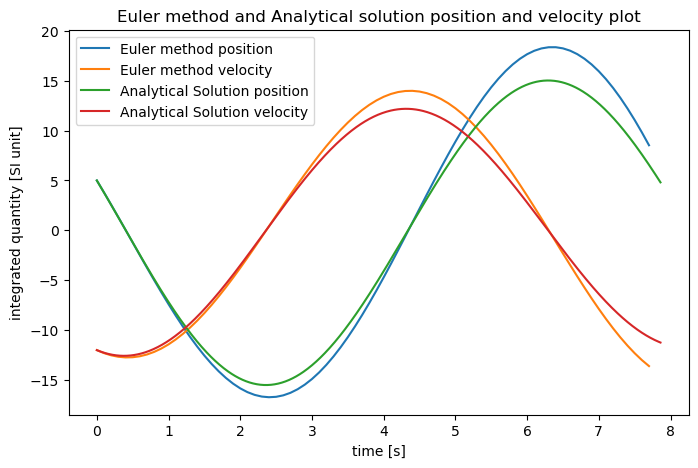

In [87]:
print("An Example of a velocity plot of the Euler"
      f" method and analytical solution with damping b = {DAMPING_CONSTANT:.3g} kg/s:")
euler_example_initial_pos, euler_example_initial_velo, euler_example_step = 5, -12, 0.1
# plot the euler method and save the axes
euler_example_axes, _uneeded_figure = plot_position_velocity(euler_method(euler_example_initial_pos,
                                                                          euler_example_initial_velo,
                                                                          PERIOD,
                                                                          euler_example_step), show=0)
# now plot the analytical solution on the same axes with the same initial conditions
plot_position_velocity(analytic_oscillator(euler_example_initial_pos,
                                           euler_example_initial_velo,
                                           PERIOD),
                       axes=euler_example_axes, show=1,
                       title="Euler method and Analytical solution position and velocity plot");
# the semicolon at the end stops jupyter from printing the outputs of the second call of plot_position_velocity

Now we can see if the numerical methods correctly reproduce the different regeimes of underdamping, overdamping and critical damping ($b = b_{cr}$).

In [88]:
def plot_cases(method, initial_position, initial_velocity, end_time=2*PERIOD, step=0.1, under = 0.2, over=2):
    """
    this plots a method for under over and critical damping for 2 periods by
    default. The under damped case is 0.2 critical and overdamped is 2 critical
    
    Parameters
    ----------
    method : function
        a numerical integration method.
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    end_time : float, optional
        time to oscillate for. The default is 2*PERIOD.
    step : float, optional
        step size of method. The default is 0.1.
    under : float < 1, optional
        what multiple of critical is underdamping. The default is 0.2.
    over : float > 1, optional
        what multiple of critical is overdamping. The default is 2.

    Returns
    -------
    None.

    """
    # do a quick run to get access to parameter values 
    _method_out = method(initial_position, initial_velocity,1, 1)
    # calculate critical damping parameter and subsequent over and under damping
    critical_damp = np.sqrt(4*_method_out["mass"]*_method_out["spring_constant"])
    under_damp = under*critical_damp
    over_damp = over*critical_damp
    
    # plotting underdamping
    ax_under, fig = plot_position_velocity(method(initial_position, initial_velocity, 
                                                  end_time, step, damping_const=under_damp),
                                           show=0, subplot=(131), figsize=(16,5))
    plot_position_velocity(analytic_oscillator(initial_position, initial_velocity, 
                                                  end_time, damping_const=under_damp), axes=ax_under,
                           title=r'Underdamped case, $b=$ 'f'{under_damp/ critical_damp}'r'$b_{cr}$',
                           show=0)
    
    # plotting overdamping
    ax_over, _fig = plot_position_velocity(method(initial_position, initial_velocity, 
                                                  end_time, step, damping_const=over_damp),show=0, 
                                           fig=fig, subplot=(133))
    plot_position_velocity(analytic_oscillator(initial_position, initial_velocity, 
                                                  end_time, damping_const=over_damp), axes=ax_over,
                           title=r'Overdamped case, $b=$ 'f'{over_damp/ critical_damp}'r'$b_{cr}$',
                           show=0)
    
    # plottng critical damping
    ax_crit, _fig = plot_position_velocity(method(initial_position, initial_velocity, 
                                                  end_time, step, damping_const=critical_damp),
                                           show=0, fig=fig,subplot=(132))
    plot_position_velocity(analytic_oscillator(initial_position, initial_velocity, 
                                                  end_time, damping_const=critical_damp), axes=ax_crit,
                           title=r'Critical case, $b= b_{cr}$')

The damping regiemes are printed below, but the Improved Euler and Verlet methods have been commented since they were similar to the Euler method and Runge Kutta Nyström methods respectively. But if the reader wishes to see them - they can simply uncomment those sections!

The Euler method:


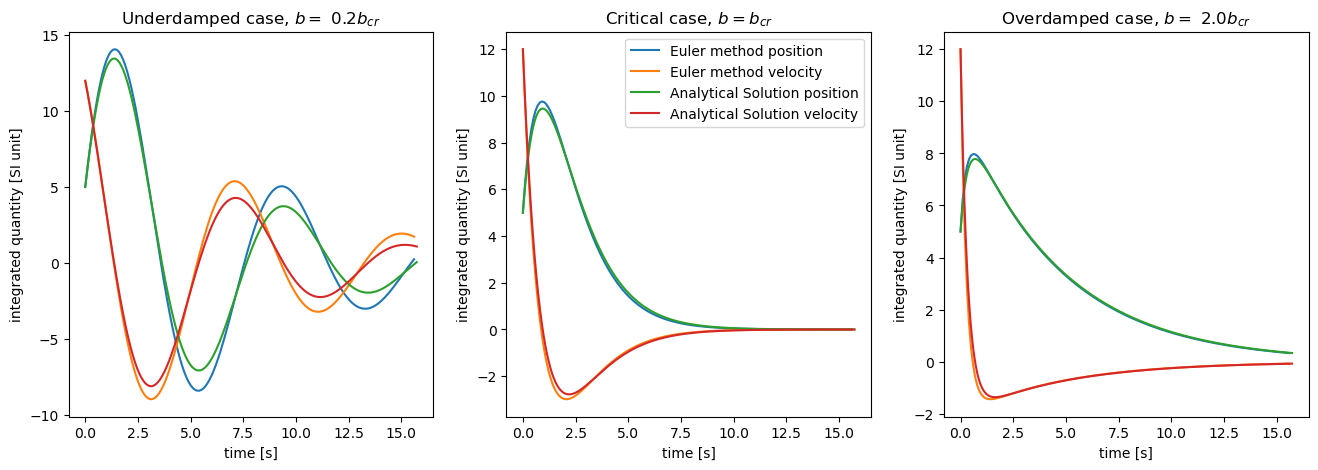

The Euler-Cromer method:


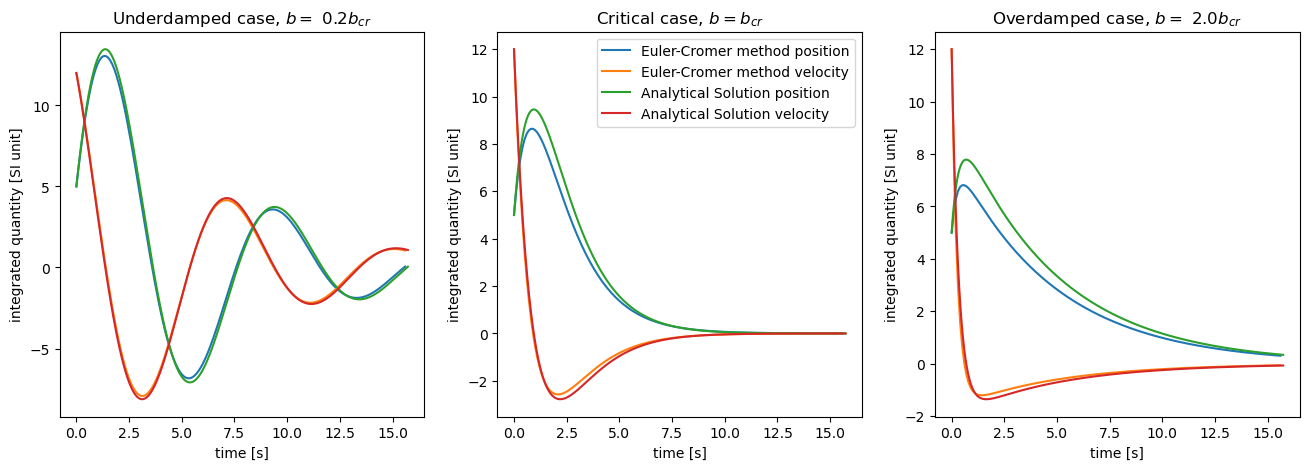

The Runge-Kutta-Nyström (4th order) method:


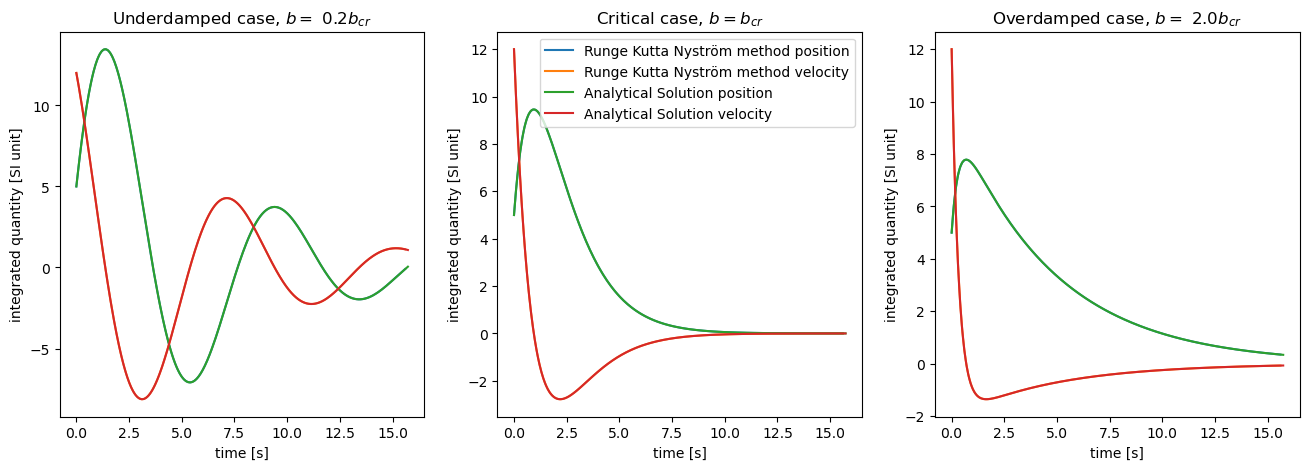

In [89]:
initial_position_cases, initial_velocity_cases = 5, 12
underdamping_factor, overdamping_factor = 0.2, 2 # setting what factor of critical damping each case is
print("The Euler method:")
plot_cases(euler_method, initial_position_cases, initial_velocity_cases,
           under=underdamping_factor, over=overdamping_factor)
#print("The Improved Euler method:")
#plot_cases(euler_method, initial_position_cases, initial_velocity_cases,
#           under=underdamping_factor, over=overdamping_factor)
print("The Euler-Cromer method:")
plot_cases(euler_cromer_method, initial_position_cases, initial_velocity_cases,
           under=underdamping_factor, over=overdamping_factor)
#print("The Verlet method:")
#plot_cases(verlet_method, initial_position_cases, initial_velocity_cases,
#           under=underdamping_factor, over=overdamping_factor)
print("The Runge-Kutta-Nyström (4th order) method:")
plot_cases(runge_kutta_nystrom, initial_position_cases, initial_velocity_cases,
           under=underdamping_factor, over=overdamping_factor)

#### Continuation of note on stiff systems - an example
It is interesting to see the effect of increasing the heavy damping factor. We see that the numerical methods struggle to properly reproduce the analytical solution unless step sizes are reduced. This is exactly as expected from the **note on stiff systems** above. For example, increasing the heavy damping to $20b_{cr}$ is shown below:

The Euler method, for extreme overdamping fails:


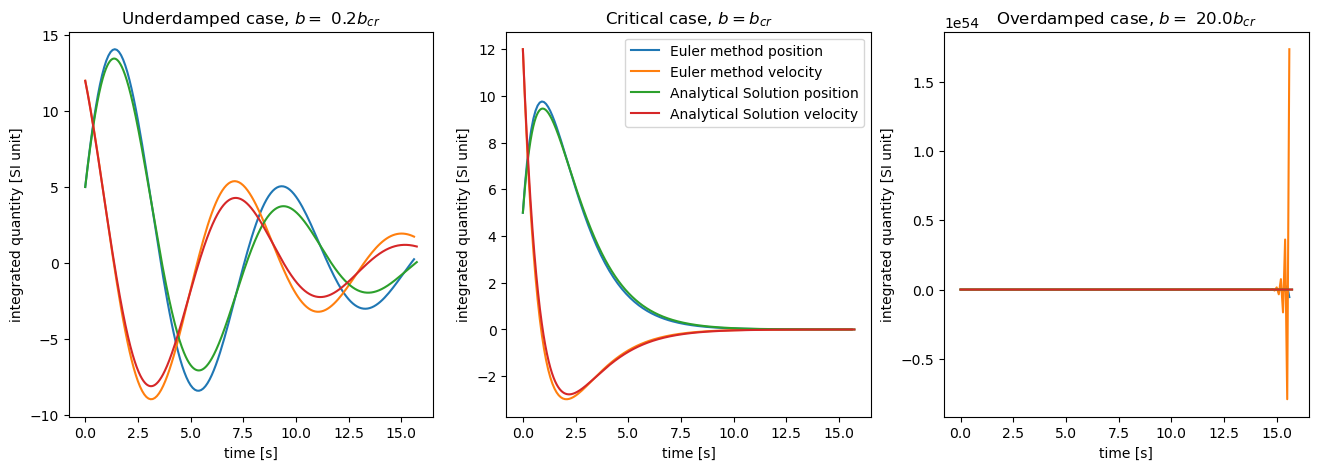

In [90]:
overdamping_factor = 20
print("The Euler method, for extreme overdamping fails:")
plot_cases(euler_method, initial_position_cases, initial_velocity_cases,
           under=underdamping_factor, over=overdamping_factor)

So indeed the damped harmonic oscillator does seem to become a stiff system in the limit of extreme damping. Decreasing time step size is the way to rectify this issue as seen below. Also, since the Verlet method has implicit aspects it performs better for a given step size.

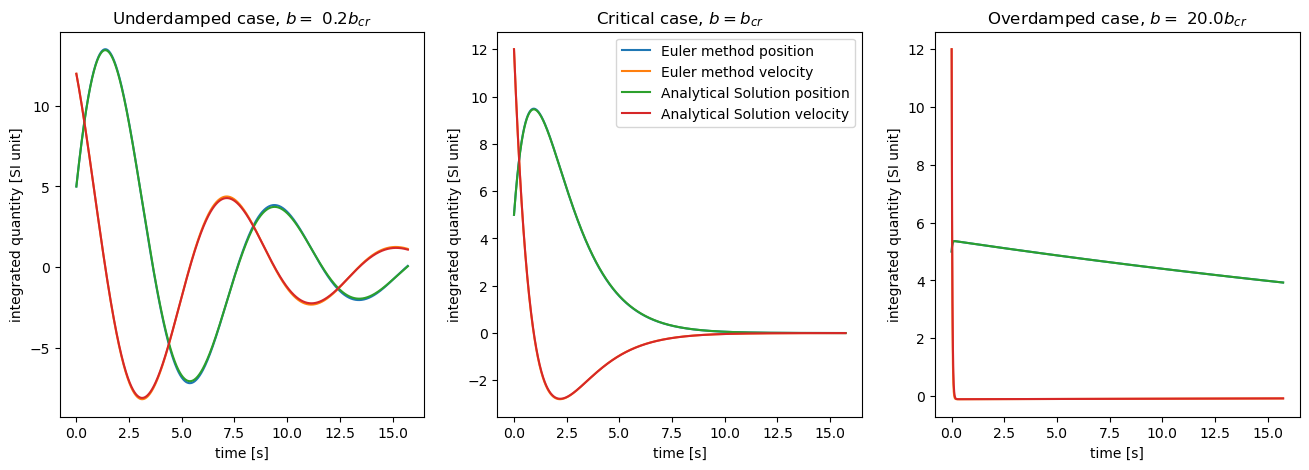

In [91]:
plot_cases(euler_method, initial_position_cases, initial_velocity_cases,
           under=underdamping_factor, over=overdamping_factor, step=0.01) # step size decreased

Phase space, which is the space of position and velocity can give insights about mechanical systems. In our system the origin is an attractor - all points in phase space eventually converge to the origin (as long as damping is present, and the system is unforced). The phase space plotting code is given by the function 'plot_phase' below. It was noted before that symplectic integrators conserve the area of a region in phase space - as that region travels around its path.

In [92]:
def plot_phase(output_dictionary, axes=None, figsize=(8,5), fig=None,
               subplot=111, show=1, title=1, autolimits = 1, legend_correction = 0):
    """
    plots the position against velocity, if no axes is provided it creates 
    a symmetic plot for the phase where the origin is at the centre. similar 
    functionality to plot_position_velocity function regarging figures and axes.

    Parameters
    ----------
    output_dictionary : dictionary
        a dictionary contaitning keys: procedure, criticality, time, position, 
        velocity.
    axes : matplotlib.axes._axes.Axes, optional
        axes to draw graph on. The default is None.
    figsize : tuple, optional
        size of figure produced if no axes or fig is provied. The default is (8,5).
    fig : matplotlib.figure.Figure, optional
        figure to put plot on, at subplot decided by 'subplot'. The default is None.
    subplot : int, optional
        subplot to place figure onto when fig provided. The default is 111.
    show : bool, optional
        choose if plt.show() is executed - set to 0 if this is not the final 
        plot on the axes. The default is 1.
    title : bool or string, optional
        if bool, then decides if figure is titled. if string input then that 
        string becomes the title. The default is 1.
    autolimits: bool, optional
        if true then as normal matplotlib decides axis limits. if false
        then looks at maximum values its plotting and makes symmetric
    legend_correction : bool, optional
        if true, places legend off the figure, to the right. The default is 0

    Returns
    -------
    axes : matplotlib.axes._axes.Axes
        axes the plot was drawn onto.
    fig : matplotlib.figure.Figure
        the figure the plot was drawn onto.

    """
    # if no figure or axes provided, create axes and figure
    if fig == None and axes==None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(subplot)
        if not autolimits:
            # make the axis symmetric
            xmax = max(np.abs(output_dictionary['position']))*1.1
            ymax = max(np.abs(output_dictionary['velocity']))*1.1
            axes.set(xlim=(-xmax,xmax),
                     ylim=(-ymax,ymax))
    # provided a figure but no axes, produce a subplot on the figure - similar procedure with axis limits
    elif fig != None and axes == None:
        axes = fig.add_subplot(subplot)
        if not autolimits:
            xmax = max(np.abs(output_dictionary['position']))*1.1
            ymax = max(np.abs(output_dictionary['velocity']))*1.1
            axes.set(xlim=(-xmax,xmax),
                     ylim=(-ymax,ymax))
    # extract strings
    procedure = output_dictionary["procedure"]
    criticality = output_dictionary["criticality"]
    # plot position and velocity against eachother
    axes.plot(output_dictionary['position'],output_dictionary['velocity'], 
              label=f'{procedure} phase')
    axes.set_xlabel("$x$ (m)")
    axes.set_ylabel("$v$ (m/s)")
    axes.axhline(0, color='gray', linewidth=0.5, alpha=0.25)
    axes.axvline(0, color='gray', linewidth=0.5, alpha=0.25)
    try:
        if len(title) > 0 and type(title)==str:
            # if the title parameter is a string of length > 0 then thats title
            axes.set_title(f'{title}')
    except TypeError: # catches if the title parameter is a boolean
        if title:
            axes.set_title(f'{procedure} position and velocity ({criticality})')
    if show: # neccessary for plotting multiple graphs on one axes or figure
        if legend_correction:
            plt.legend(bbox_to_anchor=(1, 1))
        else:
            plt.legend()
        plt.show()
    return axes, fig

Now we can plot each methods position, velocity and phase along with the analytical solution for comparison.

In [93]:
def plot_everything(initial_position, initial_velocity, end_time, step_size = 0.1,  return_result=0, plot_all=1):
    """
    this produces a superposed plot with all methods and analytical solution
    position/velocity and phase

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    end_time : float
        time to oscillate for.
    step_size : float, optional
        step size used in all methods. The default is 0.1.
    return_result : tuple of dictionaries, optional
        list of all the outputs from methods. The default is 0.
    plot_all : bool, optional
        if true then the plots are shown/ produced. The default is 1.

    Returns
    -------
    analytic_out : dictionary
        analytical method output.
    euler_out : dictionary
        euler method output.
    improved_euler_out : dictionary
        improved euler method output.
    verlet_method_out : dictionary
        verlet method output.
    euler_cromer_out : dictionary
        euler cromer method output.
    rkn_out : dictionary
        runge kutta nystrom method output.

    """
    initial_pos = initial_position # [m]
    initial_velo = initial_velocity # [m/s]
    # set step size
    step = step_size

    # allow each procedure to run: Euler, Improved Euler, Verlet, Euler-Cromer, Runge Kutta Nystrom
    euler_out = euler_method(initial_pos, initial_velo, end_time, step_size=step)
    improved_euler_out = improved_euler_method(initial_pos, initial_velo, end_time, step_size=step)
    verlet_method_out = verlet_method(initial_pos, initial_velo, end_time, step_size=step)
    euler_cromer_out = euler_cromer_method(initial_pos, initial_velo, end_time, step_size=step)
    rkn_out = runge_kutta_nystrom(initial_pos, initial_velo, end_time, step_size=step)
 
    # find analytic solution
    analytic_out = analytic_oscillator(initial_pos, initial_velo, end_time)
    
    if plot_all:
        # position and velocity plot for all methods
        print("The positions and velocities plot:")
        ax1, fig = plot_position_velocity(analytic_out, show=0)
        plot_position_velocity(euler_out, axes=ax1, show=0, title=0 )
        plot_position_velocity(improved_euler_out, axes=ax1, show=0, title=0)
        plot_position_velocity(verlet_method_out, axes=ax1, show=0, title=0)
        plot_position_velocity(euler_cromer_out, axes=ax1, title=0, show=0)
        plot_position_velocity(rkn_out, axes=ax1, show=1,title='Positions and Velocities of ' 
                               f'all methods h={step:.2f} s',
                               legend_correction=1)

        # phase plot for all methods
        print("The phase plot:")
        ax2, fig = plot_phase(analytic_out, show=0)
        plot_phase(euler_out, axes=ax2, show=0)
        plot_phase(improved_euler_out, axes=ax2, show=0)
        plot_phase(verlet_method_out, axes=ax2, show=0)
        plot_phase(euler_cromer_out, axes=ax2, show=0)
        plot_phase(rkn_out,axes=ax2, show=1, title=f'Phase plot for all methods h={step:.2f} s', 
                   legend_correction=1)
    if return_result:
        return (analytic_out, euler_out, improved_euler_out, verlet_method_out, euler_cromer_out, rkn_out)

The plotting (below) is done with a method step size of 0.1 s, so we can see the difference between methods.

The positions and velocities plot:


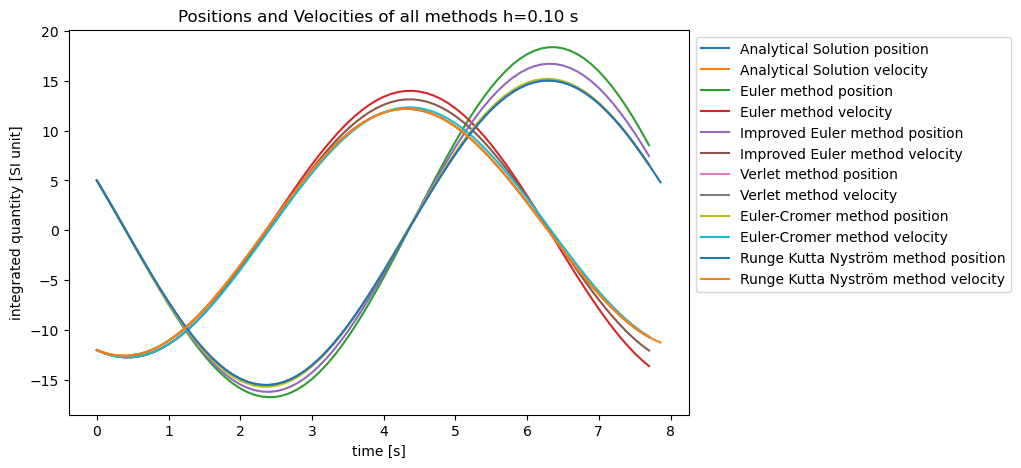

The phase plot:


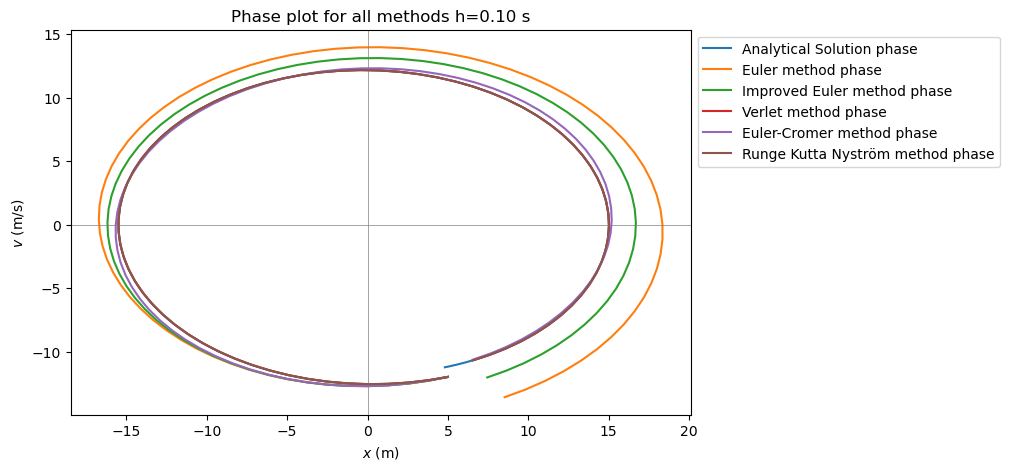

In [94]:
# perform and plot the results - the user can play with these parameters.
plot_everything(initial_position=5, initial_velocity=-12, 
                end_time=PERIOD, step_size=0.1)

Looking at the phase plot (or the position and velocity plot) - it is clear that the Runge Kutta Nyström method and Verlet method are the most accurate. This is expected since both of these methods have the smallest error. For $h = 0.1$ s, even after one period the errors accumulated by the Euler and Improved Euler methods are significiant. While the final point of Euler-Cromer method converges to the correct point - there are significant deviations partway through the oscillation.

### Investigating total mechanical energy (TME).

Below is the code for plotting the total energy TME = $\frac{1}{2}mv^2 + \frac{1}{2}kx^2$, which will be applied to the undamped Euler and Euler-Cromer methods to check what difference a symplectic method makes.

In [95]:
def plot_energy(output_dictionary, axes=None, figsize=(8,5), fig=None, 
                subplot=111, show=1, title=1, legend_correction=0):
    """
    plots the energy against time given some output dictionary. 
    able to plot onto an existing axes or figure, or produce a new figure and 
    axes. the title can be turned on of off or specifically input. and the 
    plt.show() command can be executed or skipped.

    Parameters
    ----------
    output_dictionary : dictionary
        a dictionary contaitning keys: procedure, criticality, time, position, 
        velocity.
    axes : matplotlib.axes._axes.Axes, optional
        axes to draw graph on. The default is None.
    figsize : tuple, optional
        size of figure produced if no axes or fig is provied. The default is (8,5).
    fig : matplotlib.figure.Figure, optional
        figure to put plot on, at subplot decided by 'subplot'. The default is None.
    subplot : int, optional
        subplot to place figure onto when fig provided. The default is 111.
    show : bool, optional
        choose if plt.show() is executed - set to 0 if this is not the final 
        plot on the axes. The default is 1.
    title : bool or string, optional
        if bool, then decides if figure is titled. if string input then that 
        string becomes the title. The default is 1.
    legend_correction : bool, optional
        if true, places legend off the figure, to the right. The default is 0

    Returns
    -------
    axes : matplotlib.axes._axes.Axes
        axes the plot was drawn onto.
    fig : matplotlib.figure.Figure
        the figure the plot was drawn onto.

    """
    # if no figure or axes provided, create axes and figure
    if fig == None and axes==None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(subplot)
    # if figure provided but no axes then produce an axes at subplot
    elif fig != None and axes==None:
        axes = fig.add_subplot(subplot)
    # or if axes is provided - even if figure provided - then only work with that axes and ignore the figure
    # extract strings from ouput
    procedure = output_dictionary["procedure"]
    criticality = output_dictionary["criticality"]
    # calculate the energy (works as using numpy array)
    energy = ((0.5)*output_dictionary["mass"]*(output_dictionary["velocity"]**2 )
              +(0.5)*output_dictionary["spring_constant"]*(output_dictionary["position"]**2) )
    # plot the energy
    axes.plot(output_dictionary['time'],energy, 
              label = f'{procedure} energy')
    # set labels 
    axes.set_xlabel('time [s]')
    axes.set_ylabel('Energy [J]')
    # this section is about title of the plot
    try:
        if len(title) > 0 and type(title)==str: 
            # if the title parameter is a string of length > 0 then thats title
            axes.set_title(f'{title}')
    except TypeError: # catches if the title parameter is a boolean
        if title:
            axes.set_title(f'{procedure} position and velocity ({criticality})')
    if show: # neccessary for plotting multiple graphs on one axes or figure
        if legend_correction:
            plt.legend(bbox_to_anchor=(1, 1))
        else:
            plt.legend()
        plt.show()
    return axes, fig

Now we can compare the energy of the Euler method - which we expect to steadily increase, and Euler-Cromer method which is symplectic and its energy should oscillate about the analytic energy.

In [96]:
def compare_symplectic(initial_position=5, initial_velocity=12, final_time=PERIOD, step_size=1e-2):
    """
    plots energy for non symplectic euler method and symplectic euler cromer method

    Parameters
    ----------
    initial_position : float, optional
        initial position in m. The default is 5.
    initial_velocity : float, optional
        initial velocity in m/s. The default is 12.
    final_time : float, optional
        how long oscillations occur. The default is PERIOD.
    step_size : float, optional
        step size used in the methods. The default is 1e-2.

    Returns
    -------
    None.

    """
    # set the damping to 0
    damping_constant = 0 # [kg/s]
    # call the functions for euler method and euler cromer
    euler_out_energy = euler_method(initial_position, initial_velocity, final_time,
                                    step_size, damping_const=damping_constant)
    euler_cromer_out_energy = euler_cromer_method(initial_position, initial_velocity, final_time,
                                                  step_size, damping_const=damping_constant)
    # apply the analytic solution
    analytic_out_energy = analytic_oscillator(initial_position, initial_velocity, 
                                              final_time, damping_const=damping_constant)
    # plot them all on one axes
    axes, fig = plot_energy(analytic_out_energy, show=0)
    plot_energy(euler_out_energy, axes=axes, show=0)
    plot_energy(euler_cromer_out_energy, axes=axes, title='Undamped Euler method vs Euler-Cromer')

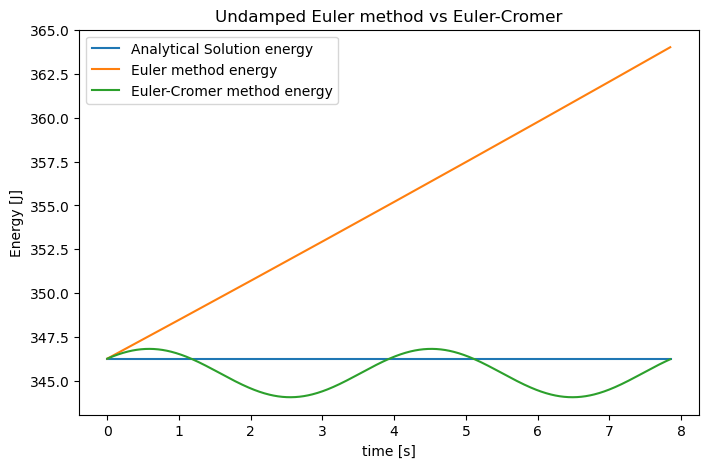

In [97]:
# call the function above
compare_symplectic()

We obtain the expected result. It is interesting to superpose all the method energies, as below. Note that a larger time step is used to illustrate the differences between the methods.

In [98]:
def compare_energy(initial_position=5, initial_velocity=12, final_time=PERIOD/2,
                   damping_constant=0, step_size=0.5, only_symplectic=0):
    """
    plots the energy against time for all methods.
    damping constant and step size can be changed

    Parameters
    ----------
    initial_position : float, optional
        initial position in m. The default is 5.
    initial_velocity : float, optional
        initial velocity in m/s. The default is 12.
    final_time : float, optional
        how long oscillations occur. The default is PERIOD/2.
    damping_constant : float, optional
        value of damping constant b in kg/s. The default is 0.
    step_size : float, optional
        step size used in the methods. The default is 0.5.
    only_symplectic : bool, optional
        if true only plots symplectic methods


    Returns
    -------
    None.

    """
    # call all the methods
    euler_out = euler_method(initial_position, initial_velocity, final_time,step_size,
                             damping_const=damping_constant)
    improved_euler_out = improved_euler_method(initial_position, initial_velocity, 
                                               final_time,step_size, damping_const=damping_constant)
    euler_cromer_out = euler_cromer_method(initial_position, initial_velocity, 
                                           final_time,step_size, damping_const=damping_constant)
    verlet_out = verlet_method(initial_position, initial_velocity, final_time,step_size, 
                               damping_const=damping_constant)
    rkn_out = runge_kutta_nystrom(initial_position, initial_velocity, final_time,
                                  step_size, damping_const=damping_constant)
    analytic_out = analytic_oscillator(initial_position, initial_velocity, final_time,
                                       damping_const=damping_constant)
    # plot analytical solution
    axes, fig = plot_energy(analytic_out, show=0)
    # plot the rest of the methods, if symplectic only verlet and euler cromer plotted
    if only_symplectic:
        plot_energy(verlet_out, axes=axes, show=0)
        plot_energy(euler_cromer_out, axes=axes, title='symplectic methods energy')
    else:
        plot_energy(euler_out, axes=axes, show=0)
        plot_energy(improved_euler_out, axes=axes, show=0)
        plot_energy(verlet_out, axes=axes, show=0)
        plot_energy(rkn_out, axes=axes, show=0)
        plot_energy(euler_cromer_out, axes=axes, title='All methods energy')

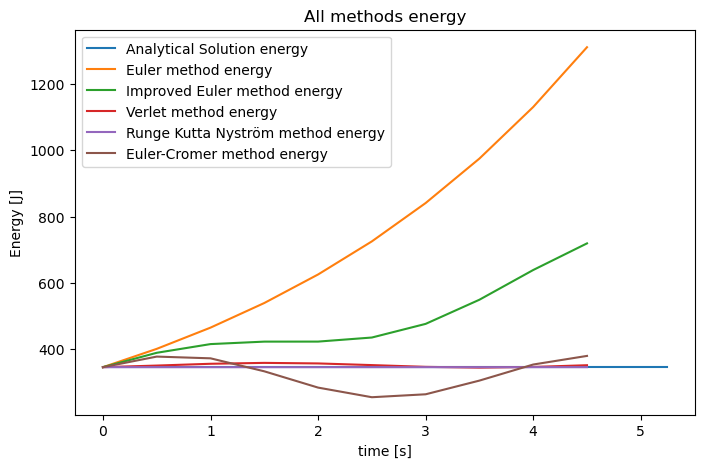

In [99]:
compare_energy(final_time=2*PERIOD/3, damping_constant=0, step_size=0.5)

We see both the Euler and Improved Euler methods quickly diverge with increasing energy. The Verlet and Euler-Cromer methods both oscillate around the analytic energy - and the plot below shows this for a longer period. The Runge-Kutta-Nyström method stays very close the the analytic energy however it is not symplectic and this is shown a bit further on. 

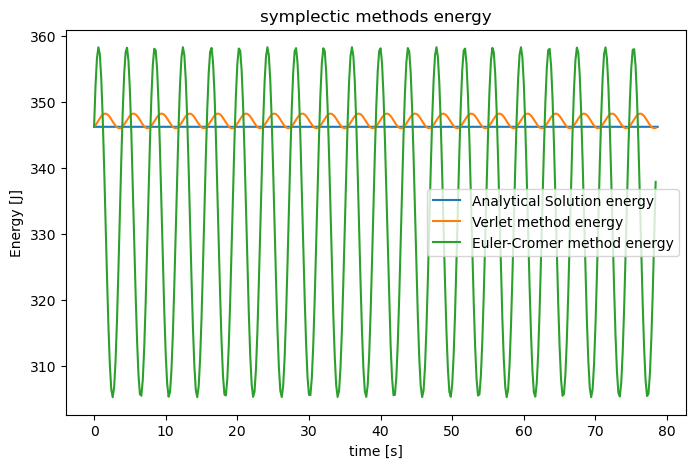

In [100]:
# plot only symplectic methods:
compare_energy(final_time=10*PERIOD, damping_constant=0, step_size=0.2, only_symplectic=1)

The energy is clearly oscillating - even at longer times. Now we can show the RKN method is not symplectic by using very large time step, as below:

In [101]:
def check_rkn_symplectic(initial_position=5, initial_velocity=12, final_time=50*PERIOD,
                         damping_constant=0, step_size=2, and_verlet=0):
    """
    plots the energy for RKN method with large timestep and long end_time 
    to see if the energy diverges

    Parameters
    ----------
    initial_position : float, optional
        initial position in m. The default is 5.
    initial_velocity : float, optional
        initial velocity in m/s. The default is 12.
    final_time : float, optional
        how long oscillations occur. The default is 50*PERIOD.
    damping_constant : float, optional
        value of damping constant b in kg/s. The default is 0.
    step_size : float, optional
        step size used in the methods. The default is 2.
    and_verlet : bool, optional
        if true also plots the verlet method for comparison. The default is 0.

    Returns
    -------
    None.

    """
    # call the methods
    analytic_out = analytic_oscillator(initial_position, initial_velocity, 
                                       final_time, damping_const=damping_constant)
    rkn_out = runge_kutta_nystrom(initial_position, initial_velocity, 
                                  final_time,step_size, damping_const=damping_constant)
    # plot the methods, and verlet method if wanted
    axes, fig = plot_energy(analytic_out, show=0)
    # write title here, so it can be edited if and_verlet true
    title = "RKN method vs analytic energy"
    if and_verlet:
        verlet_out = verlet_method(initial_position, initial_velocity, 
                                   final_time,step_size, damping_const=damping_constant)
        plot_energy(verlet_out, axes=axes, show=0)
        title += ", Verlet for comparison"
    plot_energy(rkn_out, axes=axes, show=1, title=title)

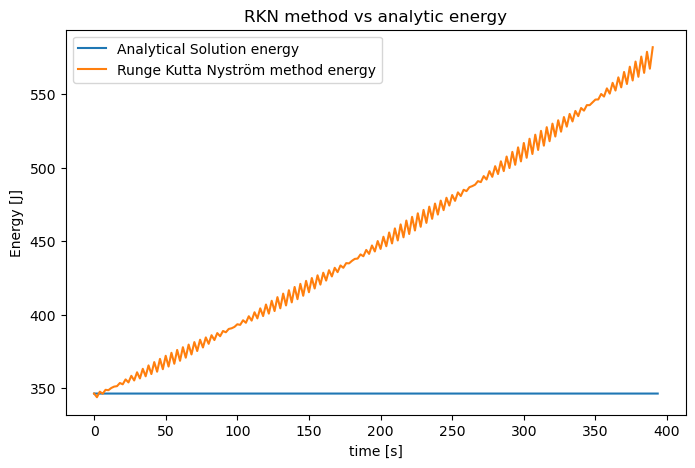

In [102]:
check_rkn_symplectic(initial_position=5, initial_velocity=12, final_time=50*PERIOD,
                     damping_constant=0, step_size=2, and_verlet=0)

As the average of the energy is diverging from the analytic constant, then it is clear to see RKN method is not symplectic. We can also plot the verlet method with this - to see how it behaves with such a large time step of $h=2$ s.

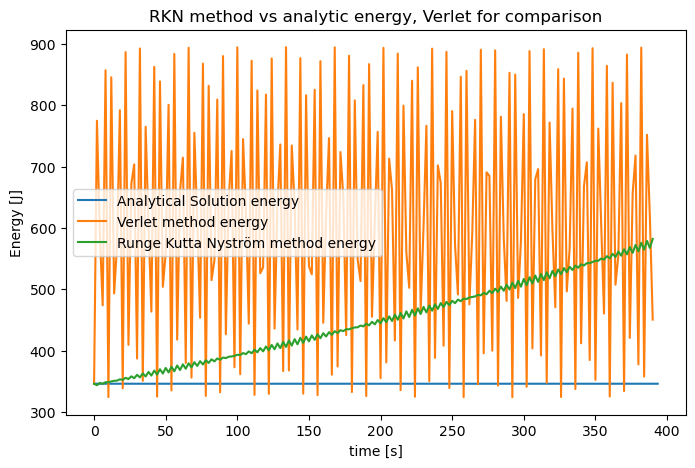

In [103]:
check_rkn_symplectic(initial_position=5, initial_velocity=12, final_time=50*PERIOD,
                     damping_constant=0, step_size=2, and_verlet=1)

So the Verlet method shows extremely large oscillations, but the average of the oscillations do not move away from the analytic energy as time increases.

### Errors

Errors occur as the numerical methods are approximations of the analytical solution. Errors can occur before calculations begin in the form of incorrectly assuming a model will fit the scenario. However, the errors that occur during the compuation are more important here, namely roundoff and truncation errors. Roundoff errors occur since computers store numbers using a finite number of bits. Truncations errors occur since we are approximating the analytical solution- these are discussed before when the error order $O(h^n)$ was noted for each method. As the step size is decreased the effect of truncation errors decrease, however this increases the need for more precise calculations which results in a larger roundoff error. More on this in **Phase 3**.

The most accurate method can be quantitatively found by comparing to the analytical solution. The absolute error is given by $|x(T)-x_{num}(T)|$ where $x(T)$ is the exact solution at some time $T$ and $x_{num}(T)$ is the numerical approximation at the same time.
We can find the absoute error as a function of time for some chosen stepsize. This way the different methods errors can be visualised.

The code below finds the global error for a chosen method.

In [104]:
def compare_error(method, initial_position, initial_velocity, end_time, step_size,
                   figsize=(8,5), pos_or_velo = "position", show=1, no_plot=0):
    """
    takes a method and finds the error by subtracting exact solution

    Parameters
    ----------
    method : function
        a numerical integration method function.
    initial_position : float
        the initial  position.
    initial_velocity : float
        the initial velocity.
    end_time : float
        the time it oscillates for.
    step_size : float
        the step size used in method.
    figsize : tuple, optional
        the tuple size of figure. The default is (8,5).
    pos_or_velo : string, optional
        either velocity or position. The default is "position".
    show : bool, optional
        decides if the plot is shown. The default is 1.
    no_plot : bool, optional
        returns only the method with new "error" key in dictionary. 
        The default is 0.

    Returns
    -------
    method_out : dictionary
        the output of a numerical method + new "error" key.

    """
    initial_pos = initial_position # [m]
    initial_velo = initial_velocity # [m/s]
    # set step size
    step = step_size

    # find analytic solution with same step size
    analytic_out = analytic_oscillator(initial_pos, initial_velo, end_time, step_size=step)
    # allow each procedure to run: Euler, Improved Euler, Verlet, Euler-Cromer, Runge Kutta Nystrom
    method_out = method(initial_pos, initial_velo, end_time, step_size=step)
    
    analytic_pos = analytic_out[pos_or_velo]
    # find difference of analytical result and numerical result
    method_pos =  method_out[pos_or_velo]
    error = np.array([])
    for index, element in enumerate(method_pos):
        difference = element - analytic_pos[index]
        error = np.append(error, np.abs(difference))
    # add this error to the output dictionary
    method_out["error"] = error
    if no_plot:
        return method_out
    # now plot the errors for each method
    fig = plt.figure(figsize=figsize)
    axes = fig.add_subplot(111)
    axes.plot(method_out["time"], method_out["error"], label=method_out["procedure"])
    # set title and axes
    axes.set_title(f"Global Error in {pos_or_velo} for h = {step_size} s")
    if pos_or_velo == "position":
        axes.set_ylabel("Absolute Error [m]")
    elif pos_or_velo == "velocity":
        axes.set_ylabel(r"Absolute Error [ms$^{-1}$]")
    axes.set_xlabel("Time [s]")
    plt.legend()
    if show:
        plt.show()
    return method_out

But its more useful to _compare_ the global errors, and so the below code plots all the global errors together - and if 'animate' is set to 1, then an animation of the global errors are produced. The animation is useful since the Verlet method and fourth order Runge Kutta Nyström method have very small errors relative to Euler and other lower order methods.

In [105]:
def plot_all_errors(initial_position, initial_velocity, end_time, step_size,
                   figsize=(9,5), pos_or_velo = "position", animate = 1):
    """
    plots the errors for all 5 methods investigated on one plot.

    Parameters
    ----------
    initial_position : float
        the initial  position.
    initial_velocity : float
        the initial velocity.
    end_time : float
        the time it oscillates for.
    step_size : float
        the step size used in method.
    figsize : tuple, optional
         the tuple size of figure. The default is (9,5).
    pos_or_velo : string, optional
        either velocity or position. The default is "position".
    animate : bool, optional
        if true an animation of the errors is produced. The default is 1.

    Returns
    -------
    None.

    """
    # collect the methods in one array
    methods = [euler_method, improved_euler_method, euler_cromer_method, 
               verlet_method, runge_kutta_nystrom]
    method_out = np.array([])
    # call the above code to return the evaluated method, plus a new "error" key
    for method in methods:
        method_result = compare_error(method, initial_position, initial_velocity,
                                      end_time, step_size, no_plot=1, pos_or_velo=pos_or_velo)
        # append this to the method_out array
        method_out = np.append(method_out, method_result)
    # the list is reversed for the animation.
    method_out = np.flip(method_out, 0)
    fig = plt.figure(figsize=figsize)
    if not animate:
        axes = fig.add_subplot(111)
        # plot all the methods on one plot
        for method in method_out:
            axes.plot(method["time"], method["error"], label=method["procedure"])
        # set title and axes
        axes.set_title(f"Global Error in {pos_or_velo} for h = {step_size} s")
        if pos_or_velo == "position":
            axes.set_ylabel("Absolute Error [m]")
        elif pos_or_velo == "velocity":
            axes.set_ylabel(r"Absolute Error [ms$^{-1}$]")
        axes.set_xlabel("Time [s]")
        plt.legend()
    if animate:
        # make axes
        axes = fig.add_subplot(111)
        # make array of integer for number of figures to plot
        step_list = np.arange(1, method_out.size+1, 1) # looks like [1 2 3 4 5]
        step_list = sorted(step_list, reverse=True) # [5, 4, 3, 2 ,1]
        steps = np.append(step_list, sorted(step_list)) # [5, 4, 3, 2 ,1, 1 ,2 ,3 ,4 ,5]
        def animate(frame):
            # clear axes- so the new axis scales
            axes.cla()
            # set figure title and axes label again since we must clear axes
            axes.set_title(f"Global Error in {pos_or_velo} for h = {step_size} s")
            if pos_or_velo == "position":
                axes.set_ylabel("Absolute Error [m]")
            elif pos_or_velo == "velocity":
                axes.set_ylabel(r"Absolute Error [ms$^{-1}$]")
            axes.set_xlabel("Time [s]")
            # now iterate and plot either 5,4,3, ... 3,4,5 lines
            for i in range(steps[frame]):
                axes.plot(method_out[i]["time"], method_out[i]["error"], label=method_out[i]["procedure"])
            # put the legend on the side
            plt.legend(bbox_to_anchor=(1, 1))
            plt.tight_layout() # needed so the legend isnt cut off
        # this is the machinery of the animation, frames with 1000 ms interval
        anim = FuncAnimation(fig, animate, frames=steps.size, interval=1000)
        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close() # close figure to stop a static image being plotted
        for method in method_out:
            axes.plot(method["time"], method["error"], label=method["procedure"]) 

Now we can compare the global errors:

In [106]:
# note if time step is decreased or end_time (PERIOD) is increased - then it may be wise to turn off animate 
# to avoid waiting too long.
print("An animation showing the global error for every method investigated:")
plot_all_errors(5, -12, PERIOD, 0.05, animate=1)

An animation showing the global error for every method investigated:


Its interesting to see the result of errors after a long time passes.

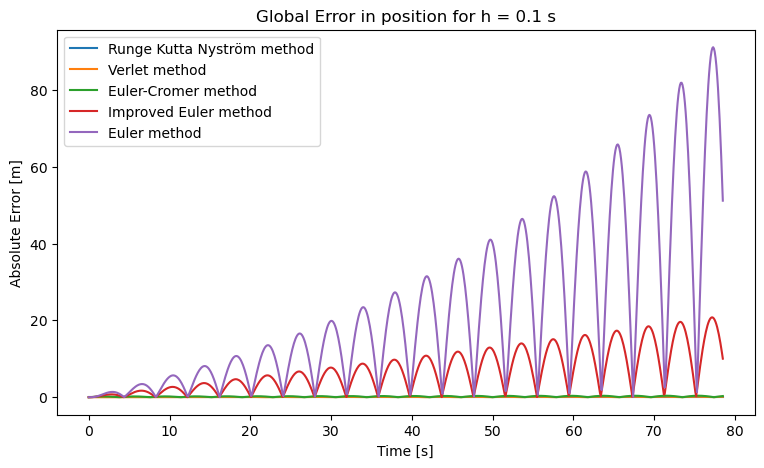

In [107]:
plot_all_errors(5, -12, 10*PERIOD, 0.1, animate=0)

The Euler method accumulates huge errors. We can see from the animation that the Runge Kutta Nyström method has the smallest errors. By a large margin too. There more than a million fold decrease in error when comparing the Euler method and RKN method (for $h=0.05$ s).

To further this point, The $\log_{10}$ can be taken so that this huge range of values can be shown clearly on one plot.

In [108]:
def plot_log_errors(initial_position, initial_velocity, end_time, step_size,
                   figsize=(8,5), pos_or_velo = "position"):
    """
    plots the log base 10 of errors for all 5 methods investigated on one plot.

    Parameters
    ----------
    initial_position : float
        the initial  position.
    initial_velocity : float
        the initial velocity.
    end_time : float
        the time it oscillates for.
    step_size : float
        the step size used in method.
    figsize : tuple, optional
         the tuple size of figure. The default is (9,5).
    pos_or_velo : string, optional
        either velocity or position. The default is "position".
    
    Returns
    -------
    None.

    """
    # collect methods
    methods = [euler_method, improved_euler_method, euler_cromer_method, 
               verlet_method, runge_kutta_nystrom]
    method_out = np.array([])
    # for each method get an output, plus a new "error" key
    for method in methods:
        method_result = compare_error(method, initial_position, initial_velocity,
                                      end_time, step_size, no_plot=1)
        method_out = np.append(method_out, method_result)
    method_out = np.flip(method_out, 0)
    # make figure and axes
    fig = plt.figure(figsize=figsize)
    axes = fig.add_subplot(111)
    # for each method plot the log base 10 for all methods on one plot 
    for method in method_out:
        # remove problematic 0 value at start (log 0)
        method["time"] = np.delete(method["time"], 0)
        method["error"] = np.delete(method["error"], 0)
        axes.plot(method["time"], method["error"], label=method["procedure"])
        axes.set_yscale('log')
    # set title
    axes.set_title(r'Global Error in 'f'{pos_or_velo} for h = {step_size} s')
    # set y axis labels
    if pos_or_velo == "position":
        axes.set_ylabel(r"Absolute Error [m]")
    elif pos_or_velo == "velocity":
        axes.set_ylabel(r"Absolute Error [ms$^{-1}$]")
    # set x axis label
    axes.set_xlabel("Time [s]")
    plt.legend()

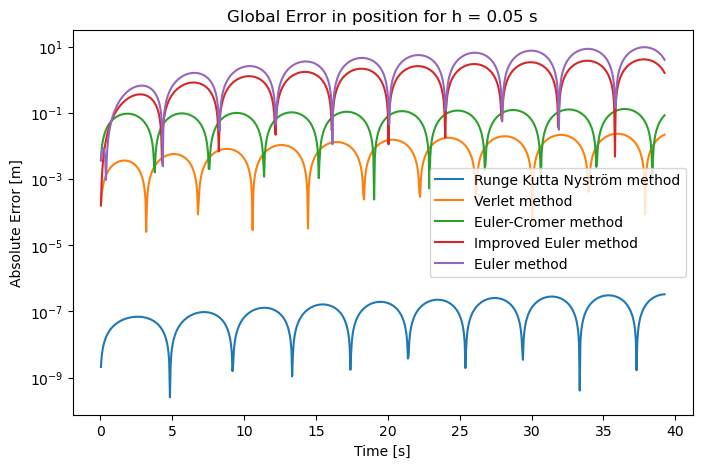

In [109]:
plot_log_errors(5, -12, 5*PERIOD, 0.05)

The fourth order Runge Kutta Nyström method is by far the most accurate method looked at in this notebook. Note that the errors also oscillate - the errors are largest at stationary points of the solution.

### Phase 3 - The Effect of Time Step $h$

Before we start: we can get an idea of how long these methods take to run for a single period, and can rank the runtime for each method when stepsize is $h=0.01$ s:

In [110]:
# the user can try rerun this cell to see variation in results
step_check_time = 0.01 # the step size
end_time_check_time = PERIOD
all_methods_out = plot_everything(initial_position=5, 
                                  initial_velocity=-12,
                                  end_time=end_time_check_time,
                                  step_size=step_check_time,
                                  plot_all=0, return_result=1)
runtime_lists = []
for method in all_methods_out:
    # append the method and runtime to runtime_lists
    runtime_lists.append([method["procedure"], method["runtime"]]) 
# order the methods
runtime_lists = sorted(runtime_lists, key=lambda x:x[1])
print("Methods in order of increasing time:")
for item in runtime_lists:
    print(f'{runtime_lists.index(item)}: {item[0]} takes {item[1]:.3e} s')

Methods in order of increasing time:
0: Analytical Solution takes 1.028e-04 s
1: Verlet method takes 1.302e-03 s
2: Euler-Cromer method takes 1.414e-03 s
3: Improved Euler method takes 1.764e-03 s
4: Euler method takes 2.509e-03 s
5: Runge Kutta Nyström method takes 4.078e-03 s


We usually see an increase in time taken as the complexity of methods increase. The slowest is normally the fourth order Runge Kutta Nyström method. Re-running the above code gives different results and there is variation for different time steps used.

## Animation of  $h$ variation

In [111]:
def animate_position_velocity(method, initial_position, initial_velocity, end_time,
                              steps = np.arange(0.01, 0.5, 0.02), figsize=(8,5)):
    """
    produces an animation of the effect of varying stepsize. 

    Parameters
    ----------
    method : function
        a numerical integration method.
    initial_position : float
        initial position in meters.
    initial_velocity : float
        initial velocity in meters per second.
    end_time : float
        end time of oscillation.
    steps : numpy array of floats, optional
        a list containing the step sizes h to have in the animation
        each element is a frame - the code will double this list and append a reverse sorted 
        version to make the animation return to original place. The default is np.arange(0.01, 0.5, 0.02).
    figsize : tuple of floats or ints, optional
        size of figure, as in matplotlib documentation. default is (8,5)

    Returns
    -------
    None.

    """
    # get a base plot with the analytical result
    ax1, fig = plot_position_velocity(analytic_oscillator(initial_position, initial_velocity, end_time),
                                      show=0, title=0, figsize=figsize) # can adjust the figsize here
    # perform one very fast run of the method to get access to procedure name
    _method_out = method(initial_position, initial_velocity,1, 1)
    print(f'Animating {_method_out["procedure"]}...')
    # set up the empty lines to be edited in the animation section
    line1, = ax1.plot([])
    line2, = ax1.plot([])
    # get the steps array and double it so the animation goes forward and backward
    step = np.append(steps, sorted(steps, reverse=True))
    def animate(frame):
        # whats being plotted every frame, where step[frame] this is changing each frame
        method_out = method(initial_position, initial_velocity, end_time, step[frame])
        # update position line
        line1.set_data((method_out['time'],method_out['position']))
        line1.set_label(f'{method_out["procedure"]} position')
        # update velocity line
        line2.set_data((method_out['time'],method_out['velocity']))
        line2.set_label(f'{method_out["procedure"]} velocity')
        # set title, with the time step value included
        ax1.set_title(f'{method_out["procedure"]} with step size h = {step[frame]:.2f}')
        plt.legend()
    # this is the machinery of the animation, frames with 200 ms interval
    anim = FuncAnimation(fig, animate, frames=step.size, interval=200)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    print(f'Animation of {_method_out["procedure"]} Complete!')
    plt.close() # close figure to stop a static image being plotted

In [112]:
animate_position_velocity(euler_method, 5, -12, PERIOD, figsize=(6,3))

Animating Euler method...


Animation of Euler method Complete!


With the Euler method as seen above, there are huge deviations at time steps only slightly bigger than 0.01. The improved Euler method gives a similar result to the basic Euler method, so it has been commented out.

In [113]:
# improved euler method
#animate_position_velocity(improved_euler_method, 5, -12, PERIOD)

The Euler-Cromer method shows improvement:

In [114]:
animate_position_velocity(euler_cromer_method, 5, -12, PERIOD, figsize=(6,3))

Animating Euler-Cromer method...


Animation of Euler-Cromer method Complete!


The verlet method shows large increase in accuracy, deviations are still small at $h=0.5$ s, and similarly for the fourth order Runge-Kutta-Nyström method. As the variations are small in the previous $h$ range, its changed to range from 0.01 to 1.00 instead. Since the Runge Kutta Nyström method and Verlet method are the two most accurate methods they have _both_ been animated below - and its interesting to see the difference when step size becomes large:

In [115]:
animate_position_velocity(verlet_method, 5, -12, PERIOD, np.arange(0.01, 1, 0.05), figsize=(8,4))

Animating Verlet method...


Animation of Verlet method Complete!


In [116]:
animate_position_velocity(runge_kutta_nystrom, 5, -12, PERIOD, np.arange(0.01, 1, 0.05), figsize=(8,4))

Animating Runge Kutta Nyström method...


Animation of Runge Kutta Nyström method Complete!


To quantitatively investigate the effect of time step for different methods, we can look at the peak error accumulated after a certain number of steps and find this error for many different time steps. The code below uses the previously defined 'compare_error' function and outputs the peak error for some step size and end time.  

In [117]:
def step_size_error(method, initial_position, initial_velocity, end_time, step_size,
                    pos_or_velo="position"):
    """
    find the absolute maximum error that occurs for a specific step size.
    and returns the value in a dictionary with new key "peak_error"

    Parameters
    ----------
    method : function
        a numerical integration method function.
    initial_position : float
        the initial  position.
    initial_velocity : float
        the initial velocity.
    end_time : float
        the time it oscillates for.
    step_size : float
        the step size used in method.
    pos_or_velo : string, optional
        either velocity or position. The default is "position".
        
    Returns
    -------
    method_result : dictionary
        the output of a numerical method + new "peak_error" key.

    """
    # find the error for some time using compare error with no_plot=1
    method_result = compare_error(method, initial_position, initial_velocity,
                                  end_time, step_size, no_plot=1, pos_or_velo=pos_or_velo)
    method_result["peak_error"] = np.max(np.abs(method_result["error"]))
    return method_result

Now we have a way of finding the peak error for some time passed, but when working with tiny step sizes its better to fix the number of steps taken to avoid runtimes that tend to infinity!. So the function below fixes the number of steps and passes a range of steps and end times (where end time is some multiple of this step size) into the function above. 'change_step_size_effect' is named as such since it finds the effect of changing the step size.

In [118]:
def change_step_size_effect(method, initial_position=5, initial_velocity=11,number_steps =5,
                            pos_or_velo="position", step_range =10**np.linspace(-10, 0, 40)):
    """
    find the peak error error for a range of step sizes chosen by step_range,
    and returns these step sizes in a dictionary

    Parameters
    ----------
    method : function
        a numerical integration method function.
    initial_position : float
        the initial  position m.
    initial_velocity : float
        the initial velocity m/s.
    pos_or_velo : string, optional
        either velocity or position. The default is "position".
    number_steps : float, optional
        how many steps per step size to find the error. The default is 5.
    step_range : array of floats, optional
        what step sizes are used. The default is 10**np.linspace(-14, 0, 20).

    Returns
    -------
    method_out : dictionary
        the output of a numerical method + new "number_steps", "step_array", 
        "peak_error_array" keys added.

    """
    # do a quick run of method to get a dictionary
    method_out = method(initial_position=initial_position, 
                        initial_velocity=initial_velocity, final_time=1, 
                        step_size=1)
    # make a new array for the errors to go into
    peak_errors = np.array([])
    for step in step_range:
        # evaluate max error for number_step step sizes for range of step sizes
        max_error = step_size_error(method, initial_position, initial_velocity, 
                                    end_time=number_steps*step, step_size=step, 
                                    pos_or_velo=pos_or_velo)["peak_error"]
        # append to array
        peak_errors= np.append(peak_errors, max_error)
    # put the results into the method out dictionary and return it
    method_out["number_steps"]= number_steps
    method_out["step_array"] = step_range
    method_out["peak_error_array"] = peak_errors
    return method_out

In [119]:
# running the above to obtain the output dictionaries - to change the number of datapoints per run
# increase the third number in the np.linspace(-14, 0, 40) defined in the function above
number_of_steps = 5
initial_position = 5 # [m]
initial_velocity = 11 # [m/s]

euler_error_out = change_step_size_effect(euler_method, 
                                          initial_position, initial_velocity, number_of_steps)
improved_euler_error_out = change_step_size_effect(improved_euler_method,
                                                   initial_position, initial_velocity, number_of_steps)
euler_cromer_error_out = change_step_size_effect(euler_cromer_method, 
                                                 initial_position, initial_velocity, number_of_steps)
verlet_error_out = change_step_size_effect(verlet_method, 
                                           initial_position, initial_velocity, number_of_steps)
rkn_error_out = change_step_size_effect(runge_kutta_nystrom, 
                                        initial_position, initial_velocity, number_of_steps)

The above can now return the error for a range of step sizes going from $10^{-10}$ to $10^0$. For example, the Euler method errors obtained are printed below (we take every third element reduce the size of the printed result) and we note that the errors increase as step size increases:

In [120]:
print("---Euler method--- \nThese are the step sizes:\n")
print(euler_error_out["step_array"][::3])
print("\nThese are the corresponding errors:\n")
print(euler_error_out["peak_error_array"][::3]);

---Euler method--- 
These are the step sizes:

[1.00000000e-10 5.87801607e-10 3.45510729e-09 2.03091762e-08
 1.19377664e-07 7.01703829e-07 4.12462638e-06 2.42446202e-05
 1.42510267e-04 8.37677640e-04 4.92388263e-03 2.89426612e-02
 1.70125428e-01 1.00000000e+00]

These are the corresponding errors:

[8.88178420e-16 1.77635684e-15 1.77635684e-15 2.66453526e-15
 9.68114477e-14 3.31112915e-12 1.14419585e-10 3.95387545e-09
 1.36722022e-07 3.55375141e-06 1.68579796e-04 6.74228886e-03
 3.99687320e-01 1.53682445e+01]


The errors can be plotted with a logarithmic axis:

In [121]:
def plot_step_error(output_dictionary, axes=None, figsize=(8,5), fig=None, 
                           subplot=111, show=1, title=1, legend_correction=0):
    """
    plots the errors with logarithmic x and y scales

    Parameters
    ----------
    output_dictionary : dictionary
        output dictionary that contain the additional keys: "peak_error_array", 
        "number_steps", "step_array".

    axes : matplotlib.axes._axes.Axes, optional
        axes to draw graph on. The default is None.
    figsize : tuple, optional
        size of figure produced if no axes or fig is provied. The default is (8,5).
    fig : matplotlib.figure.Figure, optional
        figure to put plot on, at subplot decided by 'subplot'. The default is None.
    subplot : int, optional
        subplot to place figure onto when fig provided. The default is 111.
    show : bool, optional
        choose if plt.show() is executed - set to 0 if this is not the final 
        plot on the axes. The default is 1.
    title : bool or string, optional
        if bool, then decides if figure is titled. if string input then that 
        string becomes the title. The default is 1.
    legend_correction : bool, optional
        if true, places legend off the figure, to the right. The default is 0


    Returns
    -------
    axes : matplotlib.axes._axes.Axes
        axes the plot was drawn onto.
    fig : matplotlib.figure.Figure
        the figure the plot was drawn onto.
    """
    # if no figure or axes provided, create axes and figure
    if fig == None and axes==None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(subplot)
    # if figure provided but no axes then produce an axes at subplot
    elif fig != None and axes==None:
        axes = fig.add_subplot(subplot)
    # or if axes is provided - even if figure provided - then only work with that axes and ignore the figure
    # extract strings from ouput
    procedure = output_dictionary["procedure"]
    # plot the error
    axes.plot(output_dictionary['step_array'],output_dictionary['peak_error_array'],
                 marker='o', markersize=5, linewidth=0,label = f'{procedure}')
    # set labels 
    axes.set_xlabel(r'Step size $h$ [s]')
    axes.set_ylabel(f'max error after {output_dictionary["number_steps"]} steps')
    axes.set_xscale('log')
    axes.set_yscale('log')
    # this section is about title of the plot
    try:
        if len(title) > 0 and type(title)==str: 
            # if the title parameter is a string of length > 0 then thats title
            axes.set_title(f'{title}')
    except TypeError: # catches if the title parameter is a boolean
        if title:
            axes.set_title(f'{procedure} Error ')
    if legend_correction:
        plt.legend(bbox_to_anchor=(1, 1))
    else:
        plt.legend()
    if show: # neccessary for plotting multiple graphs on one axes or figure
        plt.show()
    return axes, fig

plot_one_axis boolean will plot the errors all overlayed on one axis, or in one figure with different axis:

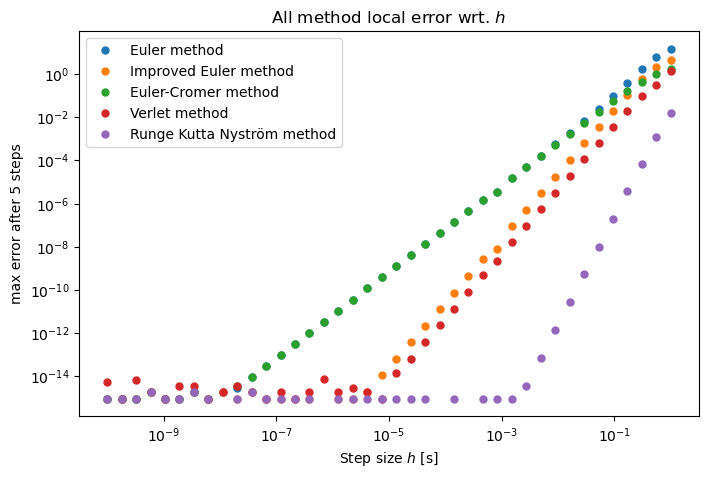

In [122]:
plot_one_axis = 1 # set to 0 to see individual error plots
if plot_one_axis == 1:
    axes, fig = plot_step_error(euler_error_out, figsize=(8,5), show=0)
    plot_step_error(improved_euler_error_out, axes=axes, show=0)
    plot_step_error(euler_cromer_error_out, axes=axes, show=0)
    plot_step_error(verlet_error_out, axes=axes, show=0)
    plot_step_error(rkn_error_out, axes=axes, show=1, title='All method local error wrt. $h$')
elif plot_one_axis == 0:
    axes, fig = plot_step_error(euler_error_out, figsize=(16,12), subplot=231, show=0)
    plot_step_error(improved_euler_error_out, fig=fig, subplot=232, show=0)
    plot_step_error(euler_cromer_error_out, fig=fig, subplot=233, show=0)
    plot_step_error(verlet_error_out, fig=fig,subplot=234, show=0)
    plot_step_error(rkn_error_out, fig=fig, subplot=235, show=1)

The minimum error is ~$10^{-15}$ which is around where the double precision limit is reached (the double precision limit is around 16 decimal places). Although an increase in error is expected after the convergence to minimum error occurs (due to rounding error), this data shows a plateau in precision. Through the plot its clear to see the error order $O(h^n)$ for each method. The Euler and Euler-Cromer method have an optimal step size of $10^{-8}$ s; Verlet and Improved Euler methods appear to converge at a similar rate with optimal step size of ~$10^{-5}$ s. By far the quickest converging is the fourth order Runge Kutta Nyström method (as expected) with an optial step size of $10^{-3}$ s. 

The best method is the 4th order Runge Kutta Nyström, and it is plotted with damping $b= \frac{1}{2}b_{cr}, b_{cr} \text{ and } 2b_{cr}$ below.

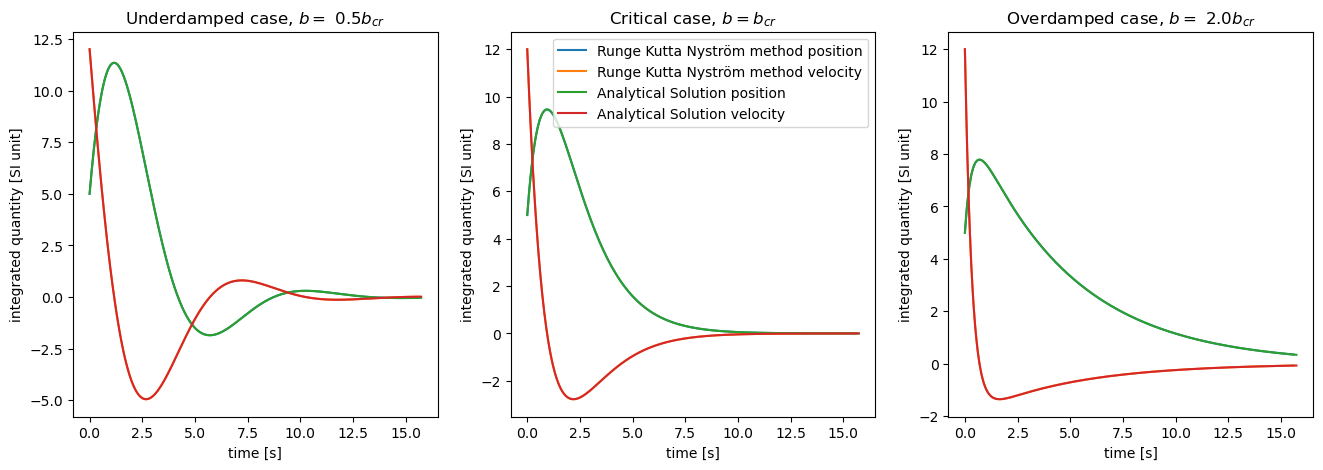

In [123]:
plot_cases(runge_kutta_nystrom, initial_position=5, initial_velocity=12, 
           under=0.5, over=2, step=0.1)

Since this is the best method, the error is invisible and hence the numerical approximation is very good. Clearly this accuracy comes at the cost of runtime - as note at the start of **phase 3** of the notebook, where the RKN method consistently ranks the slowest procedure compared to all other methods.

### Phase 4 - Applying a Force $F(t) \neq 0$

The only thing that is affected the numerical methods when a force is applied is the form of acceleration: $a(t) = - \frac{b}{m}\frac{dx}{dt}(t) - \frac{k}{m}x(t) +\frac{1}{m}F(t)$.
And putting this in a discretised form we obtain:
$a_i = - \frac{b}{m}v_i - \frac{k}{m}x_i +\frac{1}{m}F_i$, where $F_i$ is the magnitude of the force applied at the $i$th timestep.

First the code for the numerical method needs to be edited to allow for an external force - by adding a general function that only takes time as an input. This is done for the best method investigated, the fourth order Runge Kutta Nystrom (RKN):

In [124]:
def forced_rkn_method(initial_position, initial_velocity, final_time, 
                      push_function, step_size = 1e-3, mass = MASS, 
                      spring_const = SPRING_CONSTANT, damping_const = DAMPING_CONSTANT):
    """
    fourth order runge kutta nystrom method that accomodates a general force 
    force is a function of time, and has units of Newtons

     Parameters
     ----------
     initial_position : float
         the initial position in m.
     initial_velocity : float
         initial velocity in m/s.
     final_time : float
         end time of integration in seconds.
    push_function : function
        a function of time, returns a float - force in Newtons.
     step_size : float, optional
         size of step for integration in seconds. The default is 1e-3.
     mass : float, optional
         the mass m of the oscillator. The default is MASS.
     spring_const : float, optional
         spring constant k of oscillation. The default is SPRING_CONSTANT.
     damping_const : float, optional
         the damping constant b. The default is DAMPING_CONSTANT.
    
     Returns
     -------
     rkn_output : dictionary
         dictionary containting position, velocity, time arrays. the step_size, 
         final_time, mass, spring_constant, damping_constant and runtime floats.
         initial_conditions tuple. name of the procedure, the criticality of 
         oscillation strings. 
    
     """
    
    start_time = timer.time()
    # initialise 
    h = step_size
    number_steps = int(final_time/h)
    x = np.zeros(number_steps)
    v = np.zeros(number_steps)
    x[0] = initial_position #[m]
    v[0] = initial_velocity #[m/s]
    
    # produce time array
    time_array = np.empty(0)
    for i in range(x.size):
        time_array = np.append(time_array, i*h)
            
    # runge kutta nystronm method
    for i in range(number_steps-1):
        # input push function at every evaluation of 
        k1 = -(spring_const/mass)*x[i] -(damping_const/mass)*v[i] + push_function(i*h)/mass
        vk1 = v[i] + (h/2)*k1
        xk1 = x[i] + (1/6)*(h/2)*((h/2)*k1 + 4*v[i] + 2*vk1) 
        
        k2 = -(spring_const/mass)*xk1 -(damping_const/mass)*vk1 + push_function((i+0.5)*h)/mass
        vk2 = v[i] + (h/2)*k2
        xk2 = x[i] + (1/6)*(h/2)*((h/2)*k1 + 4*v[i] + 2*vk2) 
        
        k3 = -(spring_const/mass)*xk2 -(damping_const/mass)*vk2 + push_function((i+0.5)*h)/mass
        vk3 = v[i] + (h)*k3 # is this meant ot be k2 or k3
        xk3 = x[i] + (1/6)*(h)*((h)*k1 + 4*v[i] + 2*vk3) 
        
        k4 = -(spring_const/mass)*xk3 -(damping_const/mass)*vk3 + push_function((i+1)*h)/mass

        v[i+1] = v[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i+1] = x[i] + (h/6)*(v[i] + 2*vk1 + 2*vk2 + vk3)

    # check if critical, overdamped or underdamped
    critical_damp_value = np.sqrt(4*mass*spring_const)
    if cmath.isclose(damping_const, critical_damp_value):
        criticality = 'critical'
    elif cmath.isclose(damping_const, 0):
        criticality = 'undamped'
    elif damping_const > critical_damp_value:
            criticality = 'overdamped'
    elif damping_const < critical_damp_value:
            criticality = 'underdamped'
    runtime = timer.time()-start_time
    rkn_output = {'position': x, 'velocity': v, 'time' :time_array,
                  'step_size': step_size, 'final_time' : final_time,
                  'initial_conditions':(initial_position,initial_velocity),
                  'procedure': 'Runge Kutta Nyström method', 'criticality':criticality,
                  'spring_constant':spring_const, 'mass':mass, 
                  'damping_constant':damping_const, 'runtime':runtime}
    return rkn_output

#### 1. Sudden application of an external force (push)

The function for a constant force is shown below, it returns a constant 'force' value if time is between start and end. All the units used in this notebook are SI, so the force is in Newtons.

In [125]:
def constant_push(time, force, start, end=None):
    """
    force function - applies a constant force between start and end time -
    if end is None then applies a constant force after start time

    Parameters
    ----------
    time : float
        the time of the system - may be before or after push starts or ends.
    force : float
        the magnitude of the force in Newtons.
    start : float
        the start time of push.
    end : float, optional
        the end time of push. The default is None.

    Returns
    -------
    float
        returns force or 0, depending on relative values of time, start, end.

    """
    # if end is None, then just check if time is after start
    if end == None:
        if start <= time:
            return force
        else:
            return 0
    # if end is not None, check if time is also less than end
    elif end != None:
        if start <= time < end:
            return force
        else:
            return 0

An example of this is seen below (after these evaluation and plotting functions are defined):

In [126]:
def plot_force_push(initial_position, initial_velocity, end_time,force_magnitude, 
                    force_start, force_end, show, figsize=(8,5), subplot=111, fig=None,
                    damping_constant = DAMPING_CONSTANT):
    """
    takes force parameters and returns the plot of the corresponding numerical
    method position and velocity

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    end_time : float
        end time of integration in seconds.
    force_magnitude : float
        magnitude of force in newtons.
    force_start :  float
        the start time in seconds of the push
    force_end : float or None
        end time in seconds of the push.
    show : boolean
        if true, plt.show() is executed.
    figsize : tuple, optional
        tuple of floats for figsize as in matplotlib. The default is (8,5).
    subplot : int, optional
        3 integers for subplot as in matplotlib. The default is 111.
    fig : matplotlib.figure, optional
        the figure to be plotted on. The default is None.
    damping_constant : float, optional
        the damping constant for the oscillation. The default is damping_constant.

    Returns
    -------
    axes, figure
        the axes and figure of the plot that is made.

    """
    # run the code and get an output, lambda function used to input a function of time only
    forced_out = forced_rkn_method(initial_position,initial_velocity, end_time,
                                   (lambda time: constant_push(time, force_magnitude, force_start,
                                                               force_end)),
                                   damping_const = damping_constant)
    # returns axes and figure, and plots it
    axes, fig = plot_position_velocity(forced_out, figsize=figsize, title=None, 
                                       fig=fig ,subplot=subplot, show=0)
    # set a title on the plot, and plot vertical lines to indicate force start/end
    if force_end == None:
            title=(f'RKN position and velocity ({forced_out["criticality"]})'
           f'\nForced with {force_magnitude:.2g} N after {force_start/PERIOD:.2g} periods')
            axes.axvline(force_start, linestyle='--', alpha=0.75, label=f'{force_magnitude:.3g} N force,'
                         f' start at {force_start:.3g} s')
            plt.legend(fontsize=8)
    else:
        title=(f'RKN position and velocity ({forced_out["criticality"]})'
               f'\nForced with {force_magnitude:.2g} N between \n{force_start/PERIOD:.2g} '
               f'and {force_end/PERIOD:.2g} periods')
        axes.axvspan(force_start, force_end, alpha=0.25,label=f'{force_magnitude:.3g} N force'
                     f' start-end at {force_start:.3g}-{force_end:.3g} s')
        plt.legend(fontsize=8)
    axes.set_title(title)
    if show:
        plt.show()
    return axes, fig

In [127]:
def plot_cases_push(initial_position, initial_velocity, end_time, damping_constant,
                    force, force_start, force_duration, temporary_forcing):
    """
    for a given range of 3 force start times plots the position and velocity

    Parameters
    ----------
    initial_position : float
        the initial position in m.
    initial_velocity : float
        initial velocity in m/s.
    end_time : float
        end time of integration in seconds.
    damping_constant : float, optional
        the damping constant for the oscillation. The default is damping_constant.
    force : float
        magnitude of force in newtons.
    force_start :  float
        the start time in seconds of the push
    force_duration : float
        the time in seconds the force is applied for.
    temporary_forcing : boolean
        if 1 the force duration is taken into account - if 0 constnat force
        after start time.

    Returns
    -------
    None.

    """
    force_end = force_start + force_duration # [s] what time the force ends depending on duration
    if temporary_forcing==0:
        new_force_end = []
        for i in range(force_end.size):
            new_force_end.append(None)
        force_end = new_force_end
    # now plot 3 subplots
    axes, fig = plot_force_push(initial_position, initial_velocity, end_time, 
                                force, force_start[2], force_end[2], show=0, 
                                figsize=(17,4), subplot=133, damping_constant=damping_constant)
    plot_force_push(initial_position, initial_velocity, end_time, 
                    force, force_start[0], force_end[0], show=0,fig=fig, subplot=131,
                   damping_constant=damping_constant)
    plot_force_push(initial_position, initial_velocity, end_time, 
                    force, force_start[1], force_end[1], show=1,fig = fig, subplot=132,
                    damping_constant=damping_constant)

Looking at a 100 N force applied after 1/4, 1/2 and 4/5 of a period, for the undamped case:

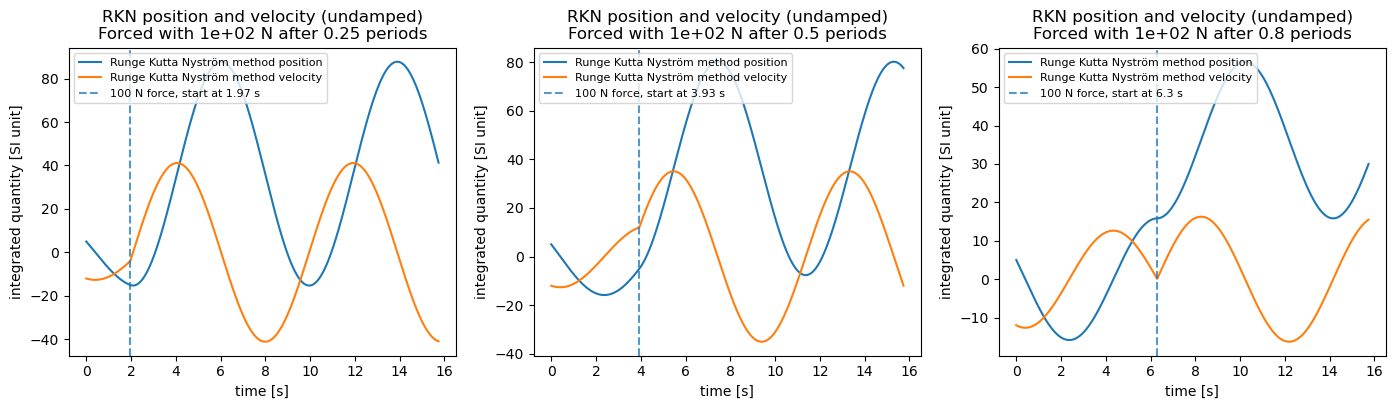

In [128]:
# this is the critical damping multiplied by constant, but change multiplier for different regimes
damping_constant = 0 # undamped

# initial conditions and end time of oscillation
initial_position = 5 # [m]
initial_velocity = -12 # [m/s]
end_time = 2*PERIOD # [s]

# FORCE magnitude and start/end time
force = 100 # [N]
force_start = np.array([0.25, 0.5, 0.8])*PERIOD # start at different fractions of the period

force_duration = 2 # [s], duration only applied if temporary_forcing (below) is set to 1
temporary_forcing = 0 

plot_cases_push(initial_position=initial_position, initial_velocity=initial_velocity, end_time=end_time,
                damping_constant=damping_constant,
                force=force, force_start=force_start, force_duration=force_duration, 
                temporary_forcing=temporary_forcing)

There is a greater increase in max displacement of position and velocity when the force magnitude has the same sign as the velocity at time of application.  The user can edit any parameters (such as damping or force magnitude) in the above cell. We can also check the behaviour for the critically damped case:

#### Looking at critical damping with a constant force

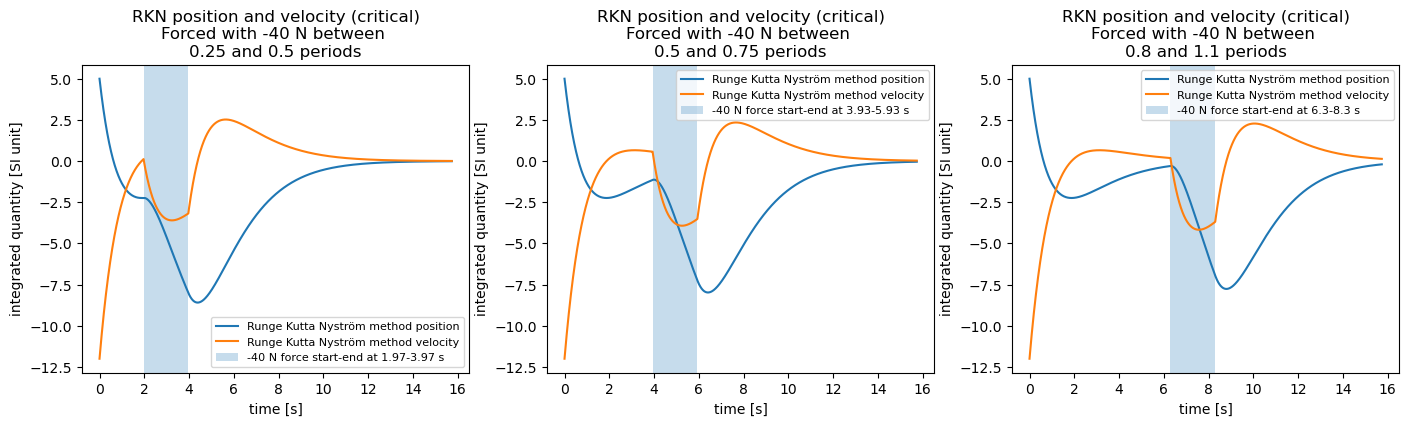

In [129]:
# change temporary forcing to 1 - so 2 second long force 
force = -40 # [N]
force_start = np.array([0.25, 0.5, 0.8])*PERIOD # start at different fractions of the period
force_duration = 2 # [s]
temporary_forcing = 1 #
# run code
plot_cases_push(initial_position=initial_position, initial_velocity=initial_velocity, end_time=end_time, # I.C
                damping_constant=CRITICAL_DAMPING, # damping
                force=force, force_start=force_start, force_duration=force_duration, # force
                temporary_forcing=temporary_forcing) # force duration

When damping is critical and a temporary force is applied, the system eventually approaches an equilibrium of 0 velocity and position no matter when the force is applied. However when a force is applied for all time after start time there is a new positional equilibrium as shown below:

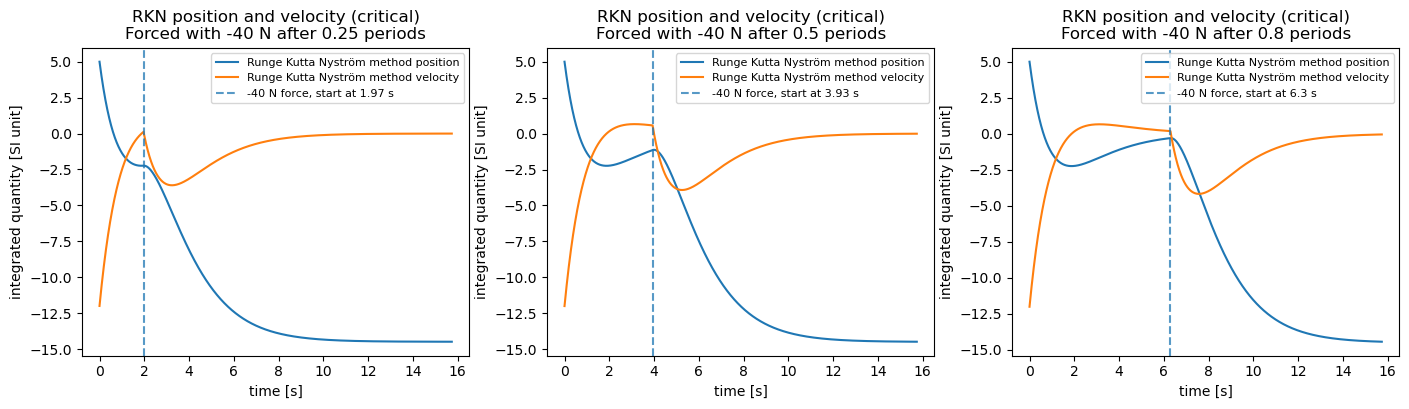

In [130]:
# using the parameters defined in the above code cell, plus changing temporary forcing to 0:
temporary_forcing = 0 #
# run code
plot_cases_push(initial_position=initial_position, initial_velocity=initial_velocity, end_time=end_time, # I.C
                damping_constant=CRITICAL_DAMPING, # damping
                force=force, force_start=force_start, force_duration=force_duration, # force
                temporary_forcing=temporary_forcing) # force duration

Where we can see the position line converges to a point other than 0. The position goes to $\sim$-15 m in the default case of this notebook. This is expected since there is a new equilibrium position when forcing is present. The applied force is $F=-40~$N, and the new equilibrium position is given by $x_{equilib} = F/k$ - inputting the values we obtain:

In [131]:
x_equilib = force/ SPRING_CONSTANT
print(f'the new eqiulibrium position is {x_equilib:.4g} m')

the new eqiulibrium position is -14.49 m


So the numerical method is in line with the analytic solution for the steady state of a constant force with non zero damping.

#### phase plots for underdamped with constant force applied

It is interesting to see the effect of an external force on the phase plot (this is for the underdamped case):

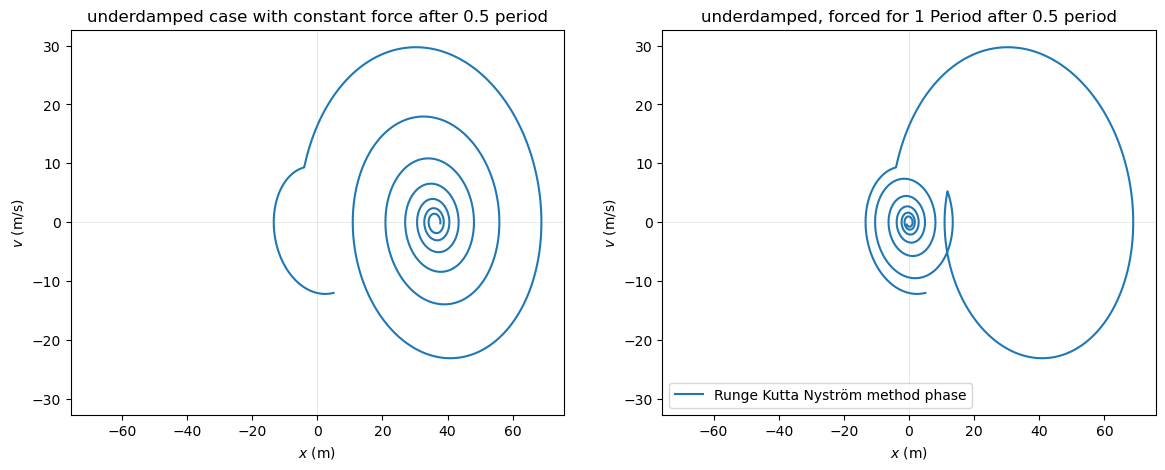

In [132]:
# define force magnitude, starting point of the force and damping of system
force_magnitude = 100 # [N]
force_start = 0.5*PERIOD # [s] pushing occurs at t = PERIOD/2
damping_constant = 0.08*np.sqrt(4*MASS*SPRING_CONSTANT) # very underdamped 0.05*critical

# run the code with non stopping force
forced_out = forced_rkn_method(initial_position=5, initial_velocity=-12, final_time=7*PERIOD,
                               push_function=(lambda time: constant_push(time, force_magnitude, force_start,
                                                                         end=None)),
                               damping_const = damping_constant)
# run code with force that stops after 1 PERIOD
forced_out_end = forced_rkn_method(initial_position=5, initial_velocity=-12, final_time=7*PERIOD,
                               push_function=(lambda time: constant_push(time, force_magnitude, force_start,
                                                                         end=force_start+PERIOD)),
                               damping_const = damping_constant)
# plot these on the same figure but different axes
axes, fig = plot_phase(forced_out, autolimits = 0, subplot=121, show=0, figsize=(14,5),
                       title=(f'{forced_out["criticality"]} case with '
                       f'constant force after {force_start/PERIOD:.2g} period'))
plot_phase(forced_out_end, fig = fig, subplot=122, autolimits=0, 
          title = f'{forced_out["criticality"]}, forced for 1 Period after {force_start/PERIOD:.2g} period');

We see that the attractor has moved away from the origin when the force is not removed! and that the origin is still the attractor for a temporary force (right).

#### 1.5 instantaneous push

Applying an instantenous force of form $F_0\delta(t-t_0)$ where $F_0$ is the magnuitude of the force applied at $t = t_0$. Since the force is instantenous the corresponding function is discontinous, so the numerical methods may fail to obtain the correct behaviour unless time step is kept small. This can be remedied by replacing the force with a narrow continous function such as a gaussian.

In [133]:
def instantaneous_push(time, force, start, variance=0.01, normalise=0):
    """
    force function - applies gaussian force centred at start. variance is small
    to make the peak sharp. modelling F = F_0*delta_function(time-start).

    Parameters
    ----------
    time : float
        the time of the system - may be before or after push starts or ends.
    force : float
        the magnitude of the force in Newtons.
    start : float
        the start time of push.
    variance : float or None, optional
        the variance of the instantaneous push, default is 0.01
    normalise: bool, optional
        if true normalisation factor is applied to the gaussian, defalt is 0

    Returns
    -------
    float
        returns force or 0, depending on relative values of time, start, end.

    """
    # evaluate the exponential
    gaussian = np.exp(-(time-start)**2/(2*variance))
    # apply normalisation if normalise is 1
    if normalise:
        gaussian *= (1/(np.sqrt(variance*2*np.pi)))
    # return the force at the time input
    return force*gaussian

The above function can be made more 'instantanous' by decreasing variance. Normalising the function (for small variance) will increase the peak height away from 1 - so the un-normalised version is used to make the peak force exerted equal to the magnitude of the force, instead of a much larger value. An example of the above is plotted below to check its behaviour:

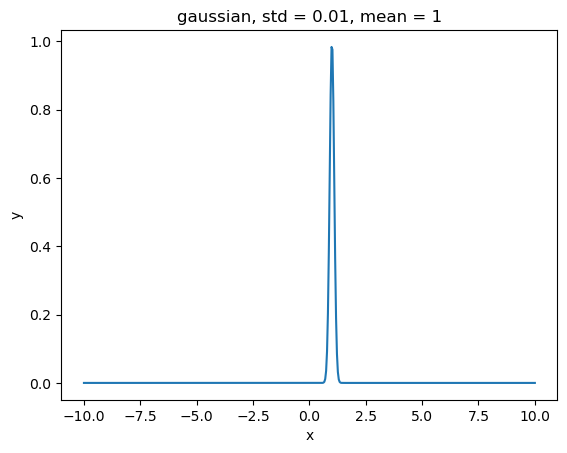

In [134]:
x = np.linspace(-10, 10, num=500)
mean, variance = 1, 0.01
y = instantaneous_push(x, force=1, start=mean, variance=variance, normalise=0)
plt.plot(x,y);
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"gaussian, std = {variance}, mean = {mean}")
plt.show()
plt.close()

Now we can investigate the effect of an 'intstantaneous' force on the oscillator:

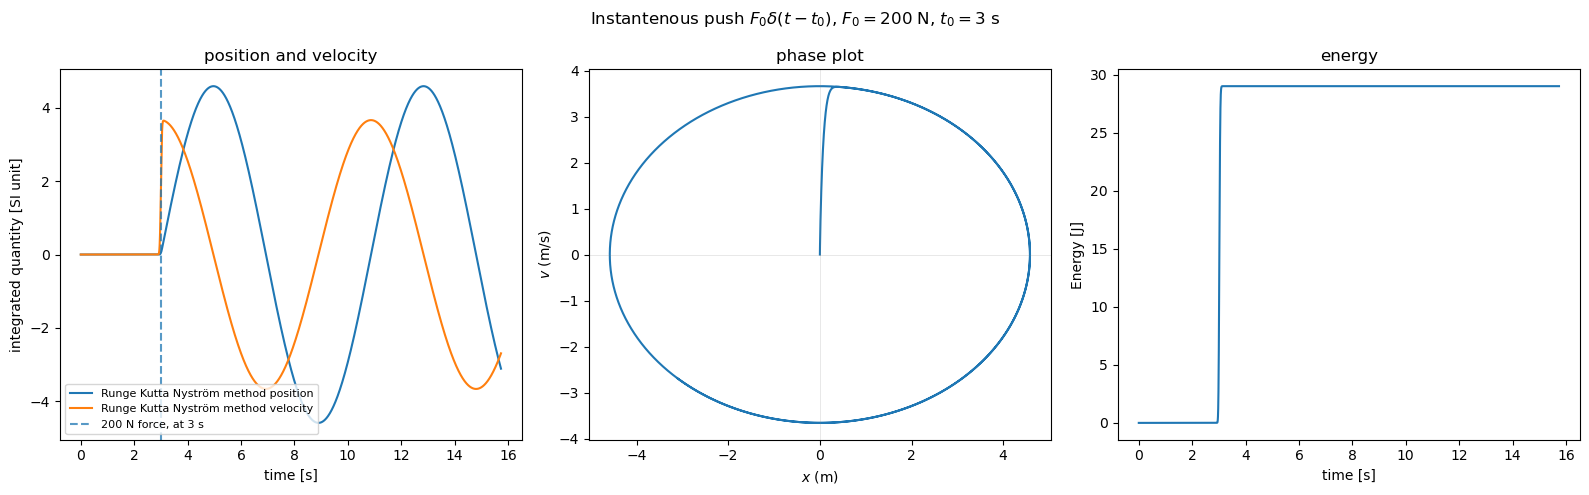

In [135]:
# set F_0, t_0 and damping constant
force_0 = 200 # [N], F_0
time_0 = 3 # [s], t_0
damping_constant = 0

# intial conditions:
initial_position = 0
initial_velocity = 0

# how long to run for
final_time = 2*PERIOD

# run the forced method with instantaneous push
instant_forced_out = forced_rkn_method(initial_position, initial_velocity, final_time,
                                       push_function=(lambda time: instantaneous_push(time, force_0, 
                                                                                      time_0, variance=0.001, 
                                                                                      normalise=0)),
                                       damping_const = damping_constant)
# plot the result
# position and velocity
axes,fig = plot_position_velocity(instant_forced_out, subplot=131, show=0, figsize=(16,5), 
                                  title=f"position and velocity")
# vertical line for force position
axes.axvline(time_0, linestyle='--', alpha=0.75, label=f'{force_0:.3g} N force,'
             f' at {time_0:.3g} s')
plt.legend(fontsize=8)
# phase plot
plot_phase(instant_forced_out, fig=fig, subplot=132, show=0, title="phase plot")
# energy plot
plot_energy(instant_forced_out, fig=fig, subplot=133, show=0, title='energy')
# title and show
plt.suptitle(fr'Instantenous push $F_0 \delta (t-t_0)$, $F_0 = {force_0}$ N, $t_0 = {time_0}$ s')
plt.tight_layout()
plt.show()
plt.close()

The user can change the initial conditions and damping/ force parameters above. But we see what is intuitively expected for initial position and velocity equal to 0; the system is 'kicked' into motion, and energy jumps to a constant value (when damping is not present).

#### 2. Sinusoidal forcing

A general sinusoidal force at some time $t$ is given by $F(t) = A\cos(2\pi f t + \phi)$, where $A$ is the amplitude of the force in Newtons, $f$ is the frequency of the driving force and $\phi$ is the phase shift. This is coded below:

In [136]:
def sinusoidal_push(time, amplitude, frequency = None, phase = 0, period=None, start_time = None):
    """    
    returns force = amplitude * cos(2*pi*frequency + phase)

    Parameters
    ----------
    time : float
        time force is to be evaluated at.
    amplitude : float
        max force to be applied - in newtons.
    frequency : TYPE, optional
        DESCRIPTION. The default is None.
    phase : float, optional
        the phase shift of the driving force. The default is 0.
    period : float, optional
        the period of driving force, if frequency also provided that takes
        priority. The default is None.
    start_time : float, optional
        if there is a start time of oscillation then the force is evaluated at 
        time - start time. The default is None.

    Returns
    -------
    float
        the force at time from a sinusoidally .

    """
    # check for period and calculate frequency
    if frequency == None and period !=None:
        input_frequency = 1/period
    elif frequency != None:
        input_frequency = frequency
    # check for start time and minus from time if present
    if type(start_time) in [float, int]:
        time = time - start_time
        if time < 0:
            return 0 
    # return the force
    return amplitude*np.cos(2*np.pi*input_frequency*time + phase)

Investigating the sinusoidal driving of an underdamped system:

when a sinusoidal force is applied we get:


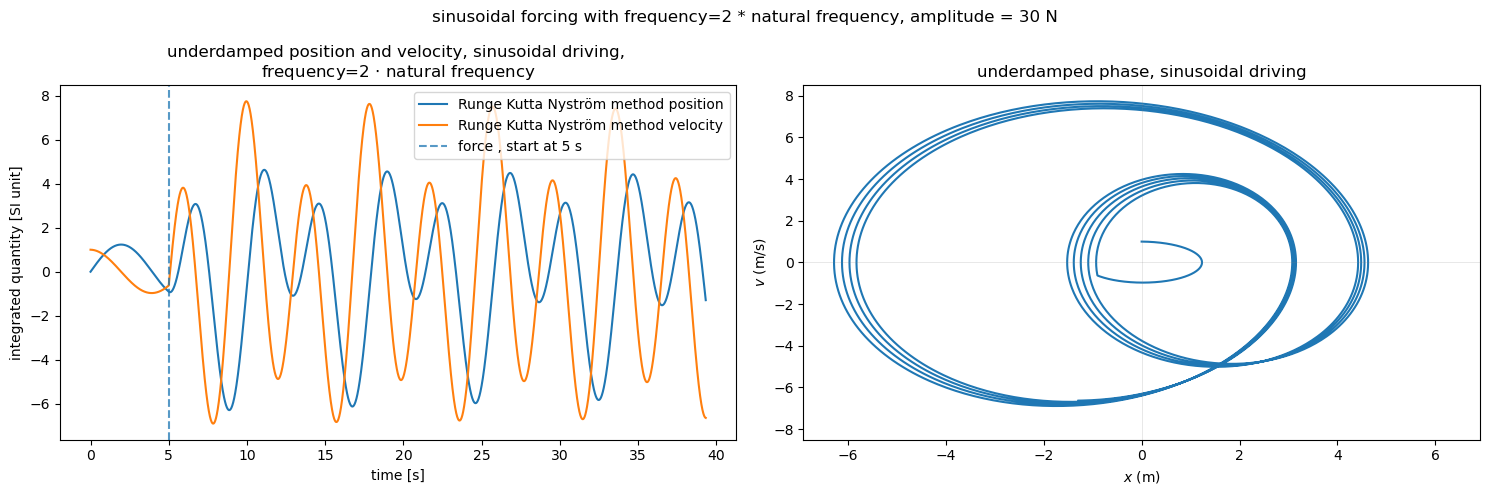

Comparing with the unforced oscillation:


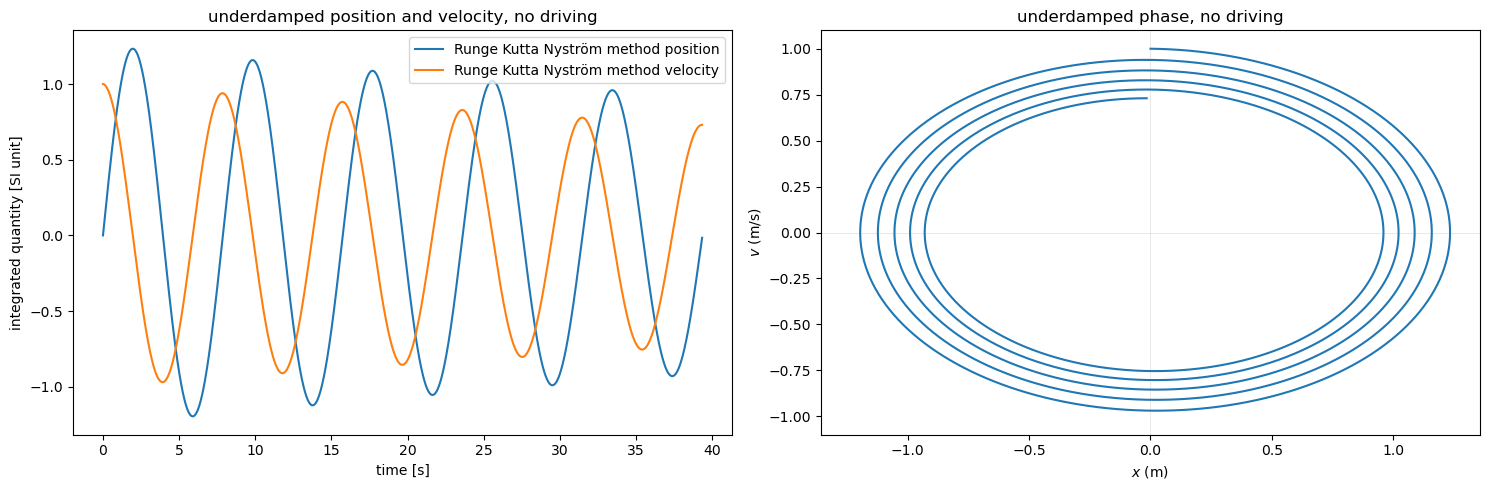

In [137]:
# set parameters of sinusoidal pushing function
amplitude = 30 # [N] 
period = 0.5*PERIOD # [s] period of driving force
start_pushing = 5 # [s] start pushing after 5 seconds
damping_constant = 0.01*CRITICAL_DAMPING # set damping here

# initial conditions and time for oscillation
initial_position = 0 # [m]
initial_velocity = 1 # [m/s]
final_time = 5*PERIOD 

# get a result for when forcing is present
print("when a sinusoidal force is applied we get:")
crit_forced_out = forced_rkn_method(initial_position,initial_velocity, final_time,
                                   push_function=(lambda time: sinusoidal_push(time, 
                                                                               amplitude=amplitude,
                                                                               period=period,
                                                                               start_time=start_pushing)),
                                   damping_const = damping_constant, step_size=0.01)
# plot the position and velocity + phase in a figure
axes, fig = plot_phase(crit_forced_out, show=0, subplot=122, autolimits=0, figsize=(15,5),
           title = f'{crit_forced_out["criticality"]} phase, sinusoidal driving')
ax1, _fig = plot_position_velocity(crit_forced_out, show=0, fig=fig, subplot=121,
                                  title=f'{crit_forced_out["criticality"]} position and velocity, '
                                   f'sinusoidal driving, \nfrequency'
                                   fr'={(1/period)/(1/PERIOD):.3g} $\cdot$ natural frequency')
ax1.axvline(start_pushing, linestyle='--', alpha=0.75, label=f'force , start at {start_pushing:.3g} s')
plt.legend()
plt.suptitle(f'sinusoidal forcing with frequency={(1/period)/(1/PERIOD):.3g} * natural frequency,'
             f' amplitude = {amplitude} N' )
plt.tight_layout()
plt.show()

# now print a comparison figure without any forcing
print('Comparing with the unforced oscillation:')
crit_unforced_out = runge_kutta_nystrom(initial_position,initial_velocity, final_time,
                                   damping_const = damping_constant, step_size=0.01)
ax2, fig2 = plot_phase(crit_unforced_out, show=0, subplot=122, autolimits=0, figsize=(15,5),
           title = f'{crit_forced_out["criticality"]} phase, no driving');
plot_position_velocity(crit_unforced_out,show=0, fig=fig2, subplot=121,
                                  title=f'{crit_forced_out["criticality"]} position and velocity, '
                                   'no driving');
plt.legend()
plt.tight_layout()
plt.show()

We see a transient at the time of force application, then settling into a steady state. The energy of the system increased (seem from the larger magnitude positions and velocities reached).

The effect of a sinusoidal drive on a critically and over damped system is shown below.

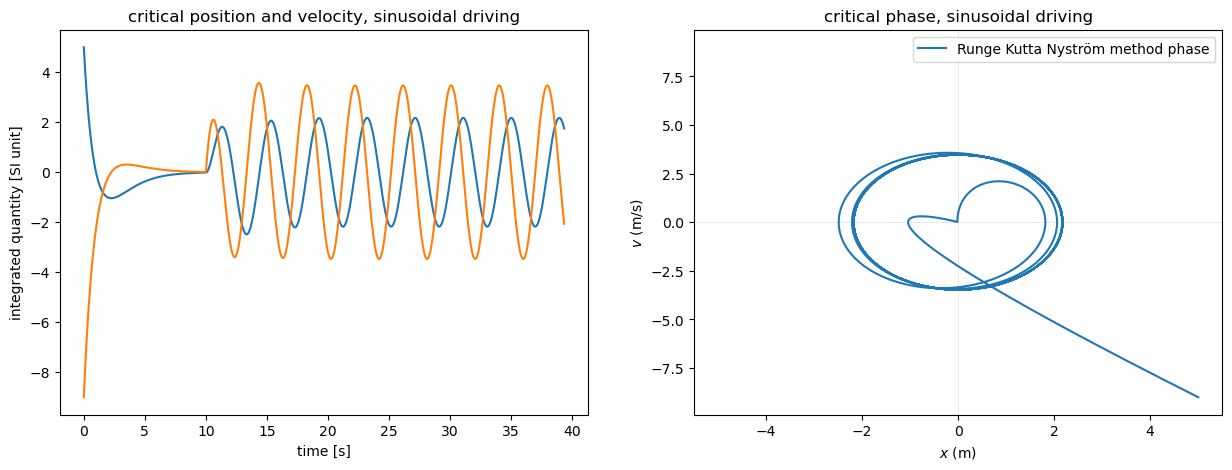

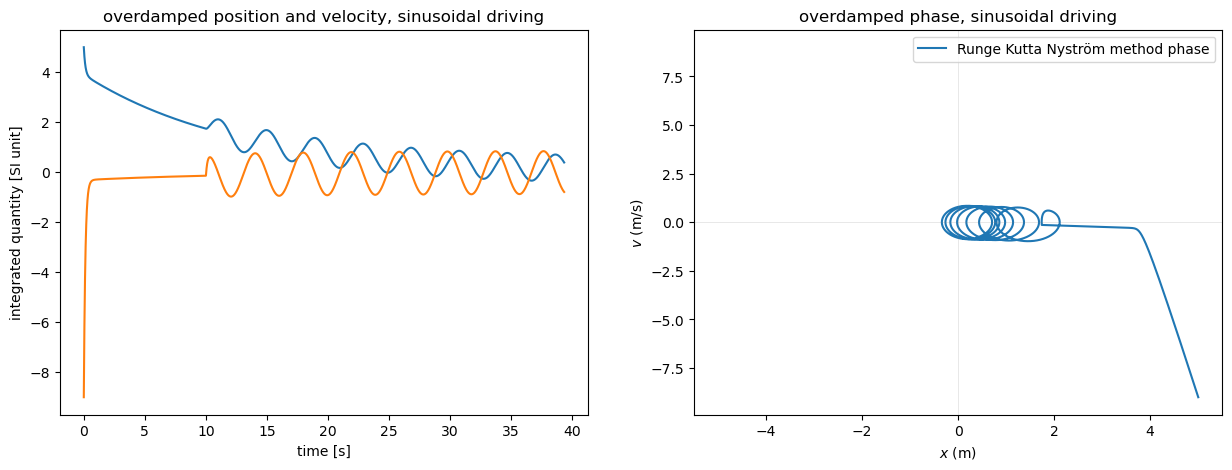

In [138]:
# set parameters of sinusoidal pushing function
amplitude = 30 # [N] 
period = 0.5*PERIOD # [s] period of driving force
start_pushing = 10 # [s] start pushing after 10 seconds
damping_constant = CRITICAL_DAMPING

# initial conditions and time for oscillation
initial_position = 5 # [m]
initial_velocity = -9 # [m/s]
final_time = 5*PERIOD 

crit_forced_out = forced_rkn_method(initial_position,initial_velocity, final_time=5*PERIOD,
                                   push_function=(lambda time: sinusoidal_push(time, 
                                                                               amplitude=amplitude,
                                                                               period=period,
                                                                               start_time=start_pushing)),
                                   damping_const = damping_constant, step_size=0.01)
axes, fig = plot_position_velocity(crit_forced_out, show=0, subplot=121, figsize=(15,5),
                                  title=f'{crit_forced_out["criticality"]} position and velocity, '
                                   'sinusoidal driving')
plot_phase(crit_forced_out, fig=fig, subplot=122, autolimits=0,
           title = f'{crit_forced_out["criticality"]} phase, sinusoidal driving')

damping_constant = 5*CRITICAL_DAMPING
over_forced_out = forced_rkn_method(initial_position,initial_velocity, final_time=5*PERIOD,
                                   push_function=(lambda time: sinusoidal_push(time, 
                                                                               amplitude=amplitude,
                                                                               period=period,
                                                                               start_time=start_pushing)),
                                   damping_const = damping_constant, step_size=0.01)
axes, fig = plot_position_velocity(over_forced_out, show=0, subplot=121, figsize=(15,5),
                                  title=f'{over_forced_out["criticality"]} position and velocity, '
                                   'sinusoidal driving')
plot_phase(over_forced_out, fig=fig, subplot=122, autolimits=0,
           title = f'{over_forced_out["criticality"]} phase, sinusoidal driving');

We see a short transient and then a settling into a steady state where the oscillations persist in critical and over damping with constant amplitude and frequency.

It is interesting to see the effect of varying damping and driving period on the phase and positional plots. The code below animates a varying damping constant for some driving period.

In [139]:
def animate_changing_damping(initial_position, initial_velocity, final_time=5*PERIOD, 
                             force_amplitude=20, force_period=2*PERIOD, figsize=(16,5)):
    """
    animates a varying damping coefficient for a sinusoidally forced system

    Parameters
    ----------
    initial_position : float
        the initial position of system in m
    initial_velocity : float
        the initial velocity in m/s.
    final_time : float, optional
        the total time oscillations occur. The default is 5*PERIOD.
    force_amplitude : float, optional
        the amplitude of driving force in newtons. The default is 20.
    force_period : float, optional
        the period of the driving force. The default is 2*PERIOD.
    figsize : float, optional
        tuple 0f figsze. The default is (16,5).

    Returns
    -------
    None.

    """
    # produce an array of steps, linspace/arange not used as more focus needed on smaller interval
    step_list = np.array([0, 0.0001, 0.0005, 0.001, 0.01, 0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    step_list = sorted(step_list, reverse=True) 
    steps = np.append(step_list, sorted(step_list))
    
    # do a quick undamped run of the system to obtain limits of the axes 
    crit_forced_out = forced_rkn_method(initial_position=initial_position,
                                        initial_velocity=initial_velocity, final_time=final_time,
                           push_function=(lambda time: sinusoidal_push(time, 
                                                                           amplitude=force_amplitude,
                                                                           period=force_period,
                                                                           start_time=0)),
                                        step_size=1, damping_const=0)
    # use previously made plotting procedures to get the correct axes limits 
    _ax1, _fig = plot_position_velocity(crit_forced_out, show=0, subplot=121, figsize=(16,5))
    _ax2, _fig = plot_phase(crit_forced_out, fig=_fig, subplot=122, autolimits=0, show=0)
    # close these figure as they are useless to see
    plt.close()
    
    # make a figure
    fig = plt.figure(figsize=figsize)
    # add a new subplot for the position and velocity
    ax1 = fig.add_subplot(121)
    # use previously found axes for limits
    ax1.set_xlim(_ax1.get_xlim())
    ax1.set_ylim(_ax1.get_ylim())
    # set labels
    ax1.set_title('position and velocity')
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('integrated quantity')
    
    # similarly as above for phase
    ax2 = fig.add_subplot(122)
    ax2.set_xlim(_ax2.get_xlim())
    ax2.set_ylim(_ax2.get_ylim())
    ax2.set_title('phase')
    ax2.set_xlabel("$x$ (m)")
    ax2.set_ylabel("$v$ (m/s)")
    
    # make 3 lines, to update later in the animation
    position, = ax1.plot([])
    velocity, = ax1.plot([])
    phase, = ax2.plot([])
    
    def animate(frame):
        """the animation function - not needed externally so less detail in the docstring"""
        # for each damping constant (decided by steps[frame]) evaluate the result when being pushed
        crit_forced_out = forced_rkn_method(initial_position=initial_position,
                                            initial_velocity=initial_velocity, final_time=final_time,
                               push_function=(lambda time: sinusoidal_push(time, 
                                                                           amplitude=force_amplitude,
                                                                           period=force_period,
                                                                           start_time=0)),
                               damping_const = steps[frame], step_size=0.01)
        # use the result to update the position line, and set its label
        position.set_data(crit_forced_out['time'],crit_forced_out['position'])
        position.set_label(f'{crit_forced_out["procedure"]} position')
        
        # update the velocity line
        velocity.set_data(crit_forced_out['time'],crit_forced_out['velocity'])
        velocity.set_label(f'{crit_forced_out["procedure"]} velocity')
        
        # update the phase line
        phase.set_data(crit_forced_out['position'],crit_forced_out['velocity'])
        phase.set_label(f'{crit_forced_out["procedure"]} phase')
    
        # make an overarching title
        plt.suptitle(f"Varing damping while forced, b = {steps[frame]/CRITICAL_DAMPING:.3g}"
                     r"$ b_{cr}$"f"\n driving force period = {force_period/PERIOD:.3g} * natural period")
        plt.tight_layout() # needed so the titles dont overlap
    # this is the machinery of the animation, frames with 250 ms interval
    anim = FuncAnimation(fig, animate, frames=steps.size, interval=250)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close() # close figure to stop a static image being plotted

When the period is equal to the natural period:

In [140]:
animate_changing_damping(initial_position=5, initial_velocity=-12, final_time=5*PERIOD,
                         force_amplitude=20, figsize=(9,5),force_period=1*PERIOD)

We see a resonance effect! where the energy in the system increases continually - which can be seen by either the expanding phase plot or increasing amplitude position and velocity plot. Plotted below is the driving frequency when it is 1/4, 3/4, 2 and 3 times the natural period.

In [141]:
print('driving period is a fourth the natural period:')
animate_changing_damping(initial_position=5, initial_velocity=-12, final_time=5*PERIOD,
                         force_amplitude=20, figsize=(9,4),force_period=0.25*PERIOD) # changing the force period

driving period is a fourth the natural period:


In [142]:
print('driving period is three fourths the natural period:')
animate_changing_damping(initial_position=5, initial_velocity=-12, final_time=5*PERIOD,
                         force_amplitude=20, figsize=(9,4),force_period=0.75*PERIOD)

driving period is three fourths the natural period:


In [143]:
print('driving period is double the natural period:')
animate_changing_damping(initial_position=5, initial_velocity=-12, final_time=5*PERIOD,
                         force_amplitude=20, figsize=(9,4),force_period=2*PERIOD)

driving period is double the natural period:


In [144]:
print('driving period is triple the natural period:')
animate_changing_damping(initial_position=5, initial_velocity=-12, final_time=5*PERIOD,
                         force_amplitude=20, figsize=(9,4), 
                         force_period=3*PERIOD) # edit the final parameter here

driving period is triple the natural period:


As damping approaches 0, the phase plots converge onto a single line. The form of the phase plots depend heavily on the period of the driving force - with mathematical knot like structures forming as damping approaches 0. When the driving period is not an exact integer multiple of the natural frequency, the phase does not converge as clearly. (the user can edit the force_period parameter above to check for themselves). The phase plots seem to 'link' (i.e there is no loose end strand) when the driving force multiplier is a specific number, such as 0.25, 0.5, 0.75, 1.25, 1.333-, 2, 3 ... and so on (at least when the system is only allowed to oscillate for 5 periods, so every period may link given enough time). This pattern even holds when, for example, the multiplier is 10 (again the user can check for themselves), so long as the simulation is allowed to run for at least 10 periods too!

Also, the specific form depends on the initial conditions. As shown below for a force with period 3 times the natural period.

Trying different initial conditions for driving force period 3 times natural period:


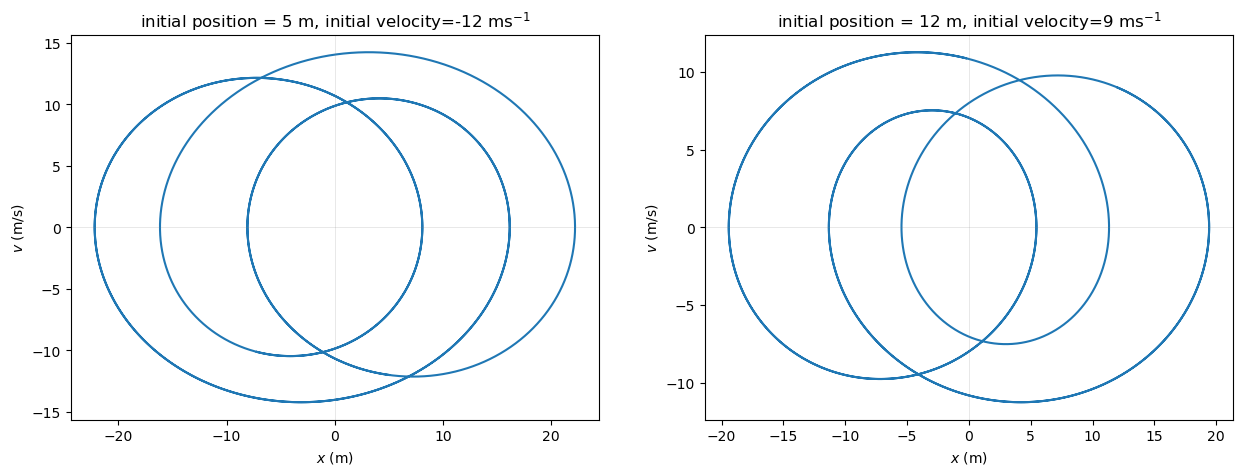

In [145]:
print("Trying different initial conditions for driving force period 3 times natural period:")
# define the pushing function
pushing_function = (lambda time: sinusoidal_push(time, amplitude=20, period=3*PERIOD, start_time=0))
# define I.C for run 1
init_pos_1, init_velo_1 = 5, -12
# run the integration
forced_3period_1 = forced_rkn_method(initial_position=init_pos_1, initial_velocity=init_velo_1, 
                                     final_time=5*PERIOD, push_function=pushing_function,damping_const=0)
# define I.C for run 2
init_pos_2, init_velo_2 = 12, 9
# run the second method with the force function and these new initial conditions
forced_3period_2 = forced_rkn_method(initial_position=init_pos_2, initial_velocity=init_velo_2, 
                                     final_time=5*PERIOD,push_function=pushing_function,damping_const=0)
# plot the runs on the same figure
axes1,fig1 = plot_phase(forced_3period_1, subplot=121, figsize=(15,5), show=0, 
                        title = f'initial position = {init_pos_1} m,'
                        f' initial velocity={init_velo_1}'' ms$^{-1}$')
plot_phase(forced_3period_2, subplot=122, fig=fig1, show=0, 
          title = f'initial position = {init_pos_2} m,'
           f' initial velocity={init_velo_2}'' ms$^{-1}$')
# show and close, show explicitly put here to avoid legend showing up on second plot
plt.show()
plt.close()

Although they look different, it seems the number of times (in the undamped case) the phase plot crosses itself has been kept constant, and is equal to 4 (when force period is 3 * natural period). These curves are called attractors since the system remains in the attractor as time increases. For the unforced damped case, the attractor was a single point at the origin. The attractor shown above is not chaotic, since slight changes in the initial conditions do not exponentially diverge the trajectories (if the initial conditions are different enough as above then different trajectories are observed).

### Phase 5- Extras, Resonance
We saw the effect of resonance when the period of the driving force was equal to the natural period. We can investigate resonance further by producing an amplitude vs driving frequency plot - where we expect a Lorentzian distribution around the natural frequency. Since we know the natural frequency, we can evaluate the amplitude for a small range around this natural frequency and plot it. The function below produces the amplitude and driving frequency array for some I.C's and other parameters:

In [146]:
def make_lorentizan(initial_position, initial_velocity, final_time=20*PERIOD,
                    damping_const = DAMPING_CONSTANT, force_amplitude=20, step=0.1):
    """
    varies the frequency around natural frequency (determined by PERIOD), and 
    then finds the peak displacement from equilibrium.

    Parameters
    ----------
    initial_position : float
        the initial position of system in m
    initial_velocity : float
        the initial velocity in m/s.
    final_time : float, optional
        the total time oscillations occur. The default is 5*PERIOD.
    damping_const : TYPE, optional
        DESCRIPTION. The default is DAMPING_CONSTANT.
    force_amplitude : float, optional
        the amplitude of driving force in newtons. The default is 20.
    figsize : float, optional
        tuple 0f figsze. The default is(8,5).
    fractional : bool, optional
        if true, normalises amplitude by diving by max amplitude. The default is 0.
    step : float, optional
        step size taken in numerical method, The default is 0.01.

    Returns
    -------
    lorentzian_output : dictionary
        dictionary containing the driving frequency and corrresponding ampitude

    """
    # find the natural period
    natural_frequency = 1/PERIOD
    # make an array of driving frequncies around this value (50 points by default)
    driving_frequency = np.linspace(0.7*natural_frequency, 1.3*natural_frequency, 50)
    # make sure natural frequency appears in this by appending it in + sorting
    driving_frequency = sorted(np.append(driving_frequency, natural_frequency))
    amplitude_array = np.array([])
    # for each frequency work run the method, with  sinusoidal pushing
    for frequency in driving_frequency:
        forced_out = forced_rkn_method(initial_position=initial_position,
                                       initial_velocity=initial_velocity,
                                       final_time=final_time, damping_const = damping_const,
                                       step_size=step,
                                       push_function=(lambda time: 
                                                      sinusoidal_push(time,
                                                                      amplitude=force_amplitude,
                                                                      frequency=frequency,
                                                                      start_time=0)))
        # find the amplitude by getting the peak of position
        amplitude = np.max(np.abs(forced_out["position"]))
        amplitude_array = np.append(amplitude_array, amplitude)
    lorentzian_output = {'driving_frequency' : driving_frequency, 
                         'amplitude_array':amplitude_array, 'damping_constant':damping_const, 
                         'natural_frequency':natural_frequency}
    return lorentzian_output

Also defining a function to plot these lorentzians:

In [147]:
def plot_lorentizan(lorentzian_output, figsize=(8,5), 
                    axes=None, show=1, fractional=0):
    """
    plots the driving frequency plus the corresponding amplitude. 
    also plots vertical line at the natural frequency

    Parameters
    ----------
    lorentzian_output : dictionary
        dictionary ouputted by make_lorentzian function
    figsize : float, optional
        tuple 0f figsze. The default is(8,5).
    axes : matplotlib.axes, optional
        an axes to draw the plot on. The default is None.
    show : bool, optional
        if true plt.show() is executed. The default is 1.
    fractional : bool, optional
        if true, normalises amplitude by diving by max amplitude. The default is 0.

    Returns
    -------
    matplotlib axes
        the axes where the plot is drawn.

    """
    driving_frequency = lorentzian_output["driving_frequency"]
    amplitude_array = lorentzian_output["amplitude_array"]
    damping_const = lorentzian_output["damping_constant"]
    natural_frequency = lorentzian_output["natural_frequency"]
    # if we want to plot fractional lorentzian, divide by max amplitude
    if fractional:
        amplitude_array = amplitude_array/ np.max(amplitude_array)
    # produce the plot and show it
    if axes is None:
        fig = plt.figure(figsize=figsize)
        axes = fig.add_subplot(111)
        axes.set_title('Amplitude vs driving frequency')
        axes.set_xlabel('driving frequency [Hz]')
        axes.set_ylabel('amplitude [m]')
        if fractional:
            axes.set_ylabel('fractional amplitude [dimensionless]')
    axes.plot(driving_frequency, amplitude_array, label= f'damping = {damping_const/CRITICAL_DAMPING:.3g} '
              r'$b_{cr}$')
    if show:
        # to stop plotting multiple same vertical lines, only plot when show=1
        axes.axvline(natural_frequency, label = f'natural frequency ({natural_frequency:.3g} Hz)',
                     linestyle='--')
        plt.legend()
        plt.show()
    return axes

Its most interesting to see the lorentizians for the underdamped and undamped cases - as overdamping and critical damping show approximately straight horizontal lines.

In [148]:
# initial conditions, although they shouldnt affect the shape of the lorentzian
initial_position = 5 #[m]
initial_velocity = -12 #[m/s]
final_time = 20*PERIOD # [s]
force_amplitude = 20 # [N]
# undamped
lorentzian_00 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0, force_amplitude=force_amplitude)
# damping is 0.01 * critical
lorentzian_01 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0.01*CRITICAL_DAMPING, force_amplitude=force_amplitude)
# damping is 0.025 * critical
lorentzian_02 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0.025*CRITICAL_DAMPING, force_amplitude=force_amplitude)
# damping is 0.04 * critical
lorentzian_03 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0.04*CRITICAL_DAMPING, force_amplitude=force_amplitude)

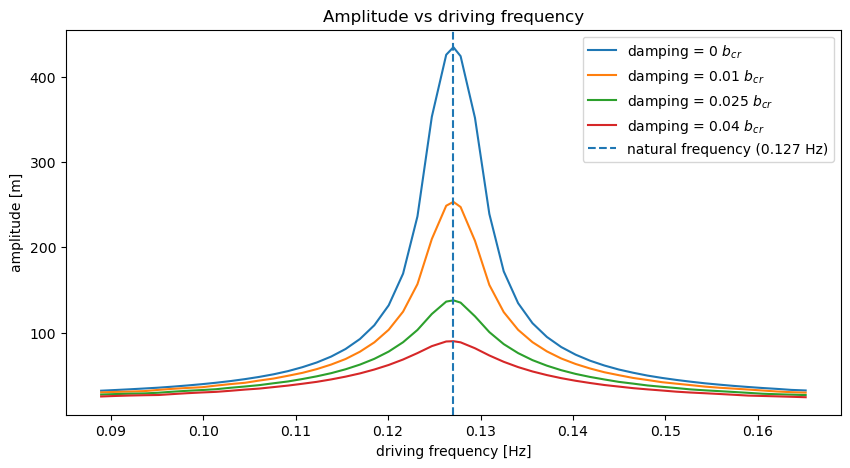

In [149]:
make_fractional = 0 # set to 1 if a fractional lorentizian is to be produced
axes = plot_lorentizan(lorentzian_00, figsize=(10,5), fractional= make_fractional, axes=None, show=0)
plot_lorentizan(lorentzian_01, fractional= make_fractional, axes=axes, show=0)
plot_lorentizan(lorentzian_02, fractional= make_fractional, axes=axes, show=0)
plot_lorentizan(lorentzian_03, fractional= make_fractional, axes=axes, show=1);

We see as expected, the characteristic lorentian curve when driving frequency varies around natural frequency. As damping is increased we see the peak broaden. We also expect the peak to move to the left as the damping increases - we can check this occurs with a higher damping example:

In [150]:
# damping is 0.1 * critical
lorentzian_04 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0.1*CRITICAL_DAMPING, force_amplitude=force_amplitude)
# damping is 0.2 * critical
lorentzian_05 = make_lorentizan(initial_position, initial_velocity, final_time=final_time,
                    damping_const = 0.2*CRITICAL_DAMPING, force_amplitude=force_amplitude)

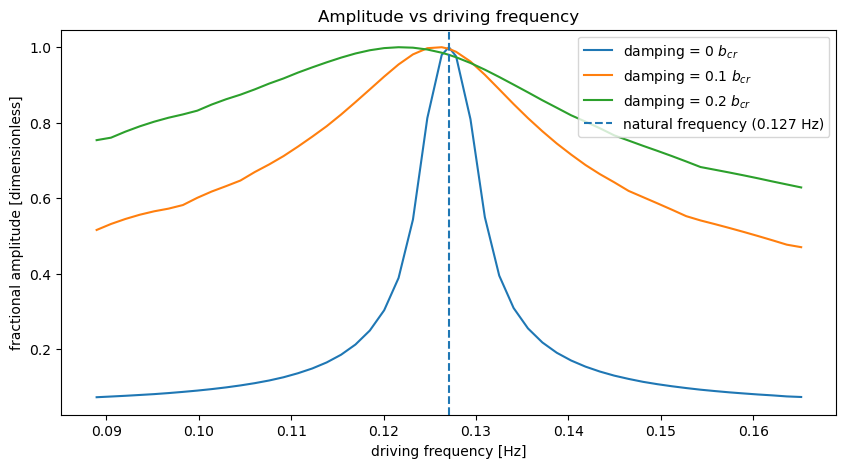

In [151]:
# plot the fractional lorentzians so the effect is easier to verify
make_fractional = 1
axes = plot_lorentizan(lorentzian_00, figsize=(10,5), fractional= make_fractional, axes=None, show=0)
plot_lorentizan(lorentzian_04, fractional= make_fractional, axes=axes, show=0)
plot_lorentizan(lorentzian_05, fractional= make_fractional, axes=axes, show=1);

Its clear to see when the fractional Lorentzians are plotted that the peak is migrating to the left as expected! So the numerical method is able to accurately reproduce the effect of resonance!